## Import Libraries

In [277]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from pandas.io.formats.style import Styler
from pathlib import Path
from typing import Any, Callable, Dict, List, TypeVar

In [2]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
!pwd

/home/xavi/Documents/CreditRisk/notebooks


In [4]:
file: Path = Path('/home/xavi/Documents/CreditRisk/data/curated/dataset.parquet')

In [5]:
df: pd.DataFrame = pd.read_parquet(file, engine='pyarrow')

### Depedent variable:

In [6]:
df['loan_status'].value_counts(dropna=False, normalize=True)

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [7]:
defaults: List[str] = [
    'Charged Off',
    'Late (31-120 days)',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

In [8]:
is_in_defaults: Callable  = defaults.__contains__

In [10]:
df['non_default'] = df['loan_status'].apply(lambda v: 0 if is_in_defaults(v) else 1)

In [18]:
(df['non_default'].value_counts()/ len(df)).apply('{0:.2%}'.format)

non_default
1    89.07%
0    10.93%
Name: count, dtype: object

### Train-test split

In [19]:
SEED = 19

In [142]:
PROPORTION = .9

In [143]:
is_in_train_set = df['non_default'].reset_index()\
                                   .groupby('non_default', group_keys=False)\
                                   .apply(lambda s: s.sample(frac=PROPORTION, random_state=SEED))['id'].values

In [144]:
df['is_in_train'] = df.index.isin(is_in_train_set)

In [145]:
df['is_in_train'].value_counts()/len(df)

is_in_train
True     0.899999
False    0.100001
Name: count, dtype: float64

In [146]:
df_train = df[df['is_in_train']].copy()

In [147]:
df_train.shape

(419656, 79)

In [149]:
df_train['non_default'].value_counts()/len(df_train)

non_default
1    0.890694
0    0.109306
Name: count, dtype: float64

### Indepent variables

#### Discrete variables

In [150]:
category_mask: pd.Series = df_train.dtypes == 'category'

In [151]:
categories: List[str] = df_train.dtypes[category_mask].index.to_list()

In [152]:
cat_df: pd.DataFrame = df_train[categories + ['non_default']].drop('issue_d', axis=1)

In [153]:
categories.remove('issue_d')
categories.remove('loan_status')

In [154]:
categories

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'policy_code',
 'application_type']

**WoE and IV calculation**:

In [158]:
def calculate_woe_iv(data:pd.DataFrame, variable:pd.Series, target:pd.Series, multilevel_index:bool = False, sort_by_woe: bool = True, aggfunc: Callable = len) -> pd.DataFrame:
    pivot = pd.pivot_table(data=data, index=variable, columns=target, aggfunc=aggfunc, fill_value=0, values=[])
    pivot['n_obs'] = pivot.apply(axis=1, func=np.sum)
    pivot['n_obs_rel'] = pivot['n_obs'] / pivot['n_obs'].sum()

    #add .00000005 to handle errors when calculating WoE (ln(0))
    pivot['bad_rel'] = (pivot[0] + .00000005) / pivot[0].sum()
    pivot['good_rel'] = (pivot[1] + .00000005) / pivot[1].sum()

    pivot['woe'] = np.log(pivot['good_rel']) - np.log(pivot['bad_rel'])

    if sort_by_woe:
        pivot = pivot.sort_values(by='woe', ascending=True)

    else:
        pivot = pivot.sort_index(ascending=True)
        
    pivot['good_rel_diff'] = pivot['good_rel'].diff().abs()
    pivot['bad_rel_diff'] = pivot['bad_rel'].diff().abs()
    pivot['woe_diff'] = pivot['woe'].diff().abs()
    pivot['accum_n_obs_rel'] = pivot['n_obs_rel'].cumsum()
    
    pivot['iv'] = ((pivot['good_rel'] - pivot['bad_rel']) * pivot['woe']).sum()
    
    if multilevel_index:
        pivot['variable'] = variable.name
        pivot = pivot.set_index(['variable', pivot.index])

    if sort_by_woe:
        return pivot.sort_values(by='woe', ascending=True)

    return pivot.sort_index(ascending=True)

In [159]:
def run_woe_iv(data:pd.DataFrame, independent_vars:List[str], dependent_var:str) -> pd.DataFrame:
    accum: pd.Dataframe = pd.DataFrame([])
    for v in independent_vars:
        result = calculate_woe_iv(data[[v, dependent_var]], data[v], data[dependent_var], multilevel_index=True)
        accum = pd.concat([accum, result], axis=0)

    return accum

In [160]:
calculate_woe_iv(cat_df, cat_df['grade'], cat_df['non_default'], multilevel_index=True)

non_default         0       1   n_obs  n_obs_rel   bad_rel  good_rel  \
variable grade                                                         
grade    G        843    2158    3001   0.007151  0.018378  0.005773   
         F       2886    9089   11975   0.028535  0.062916  0.024316   
         E       6292   25971   32263   0.076880  0.137167  0.069481   
         D      10647   58492   69139   0.164752  0.232107  0.156486   
         C      12944   99728  112672   0.268487  0.282183  0.266806   
         B       9683  113551  123234   0.293655  0.211092  0.303787   
         A       2576   64796   67372   0.160541  0.056157  0.173351   

non_default          woe  good_rel_diff  bad_rel_diff  woe_diff  \
variable grade                                                    
grade    G     -1.157877            NaN           NaN       NaN   
         F     -0.950654       0.018543      0.044538  0.207223   
         E     -0.680146       0.045165      0.074252  0.270508   
         D     -0.394236       0.087005      0.094940  0.285910   
         C     -0.056034       0.110320      0.050075  0.338202   
         B      0.364033       0.036981      0.071091  0.420066   
         A      1.127158       0.130436      0.154934  0.763126   

non_default     accum_n_obs_rel        iv  
variable grade                             
grade    G             0.007151  0.293839  
         F             0.035686  0.293839  
         E             0.112566  0.293839  
         D             0.277318  0.293839  
         C             0.545804  0.293839  
         B             0.839459  0.293839  
         A             1.000000  0.293839

**Style Woe calculations**

In [253]:
def style_woe_frame(d: pd.DataFrame) -> Styler:
    index_style = """background-color: #b20f4f;
                     border-width: 2px;
                     border-color: #ffffff;
                     border-style: solid;
                     text-align: center;
                  """
    below_five_pct_style = """
                     background-color: #cc5040;
                     border-width: 1px;
                     border-color: #ffffff;
                     border-style: dashed;
                  """

    colours: List[str] = ['#f0a324', '#f0d424', '#c4daaa', '#aad140', '#91f024', '#ef6852']
    nodes: List[float] = [0, .02, .1, .3, .5, 1]
    cmap = LinearSegmentedColormap.from_list('iv_map', list(zip(nodes, colours)))
    
    return d.style.format(thousands=',', precision=3)\
            .apply_index(lambda s: pd.Series(index_style, index=s.index), axis=0)\
            .apply_index(lambda s: pd.Series(index_style, index=s.index), axis=1)\
            .bar(color=('#de9910', '#7acd53'), align='zero', subset=['woe'], width=80, height=80)\
            .format('{0:.2%}', subset=['n_obs_rel', 'bad_rel', 'good_rel', 'accum_n_obs_rel'])\
            .set_caption('Weight of evidence analysis for variables: {0}'.format(d.index.names[1]))\
            .highlight_between(subset=['n_obs_rel'], props=below_five_pct_style, left=0, right=.05, inclusive='right')\
            .background_gradient(cmap=cmap, vmin=0, vmax=1, subset=['iv'])

In [254]:
style_woe_frame(calculate_woe_iv(cat_df, cat_df['grade'], cat_df['non_default'], multilevel_index=True))

In [240]:
woe_summary = run_woe_iv(data=cat_df, independent_vars=categories, dependent_var='non_default')

In [241]:
woe_summary.groupby(level=0)['iv'].max().sort_values(ascending=False).apply(lambda v: '{0}'.format(str(v)))

variable
sub_grade                 0.31801257871646604
grade                     0.29383944484595614
term                      0.03964422510341349
purpose                   0.03678649744024622
initial_list_status      0.024876385244176548
home_ownership            0.02134309680189488
verification_status       0.02044927654461296
addr_state               0.012440268872908673
emp_length               0.005116449325983384
pymnt_plan             0.00013840433948306575
application_type        9.145978886378884e-25
policy_code             9.145978886378884e-25
Name: iv, dtype: object

In [255]:
style_woe_frame(woe_summary)

**Plot WoE**:

In [258]:
def plot_woe(woe_series: pd.Series, labels: pd.Series | None = None):
    fig = plt.figure(figsize=(18, 6))

    style_dict = {
                  'xlabel': 'Categories',
                  'title': '{0}'.format(woe_series.name),
                 }
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    
    rotate = False
    if isinstance(woe_series.index.values[0], pd.Interval):
        x =  list(map(str, woe_series.index.values))
        rotate = True
        
    else:
        x = woe_series.index.values
        
    ax.plot(x, woe_series.values, color='red', marker='o', linestyle='--')

    if rotate:
        ax.set_xticks(np.arange(0, len(x)))
        ax.set_xticklabels(x, rotation = 90)
        
    if labels is not None:
        for (i, label), value in zip(enumerate(labels.values), woe_series.values) :
            ax.text(i, value + 0.1, label)
            
    return ax

<Axes: title={'center': 'woe'}, xlabel='Categories'>

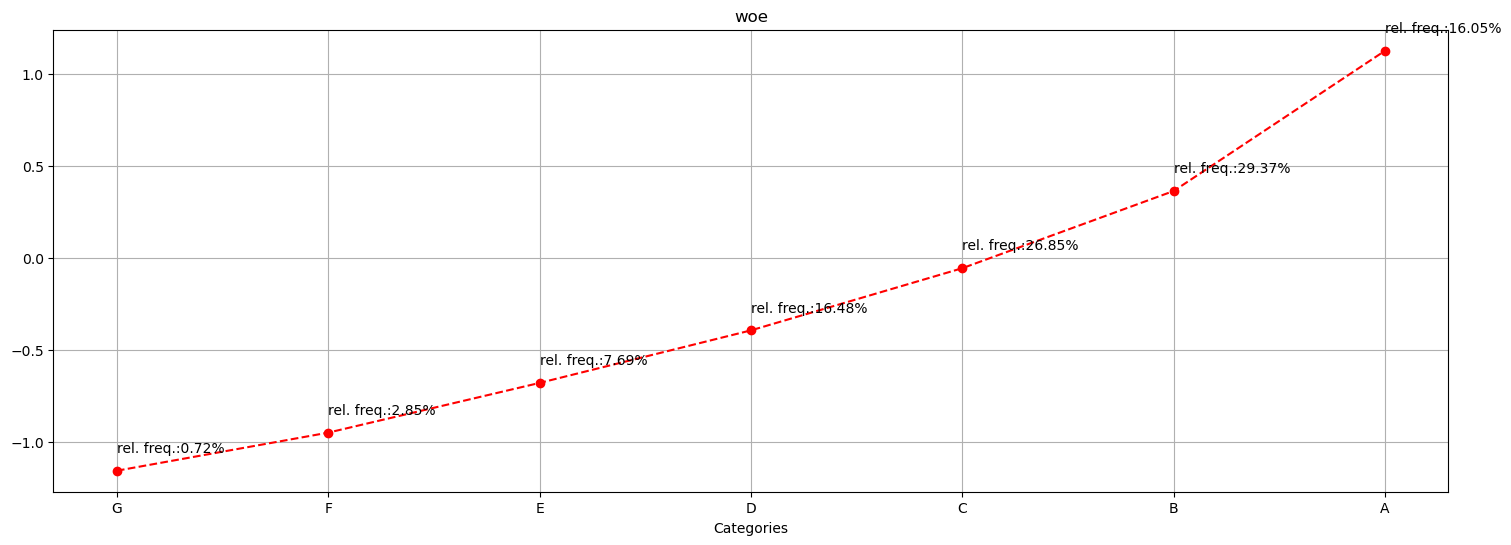

In [259]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{0:.2%}'.format(v)))

**Coarse classing mechanism**

In [403]:
from collections.abc import Iterable
import abc

PathLike = TypeVar('PathLike', str, Path, None)

class Component(Iterable, abc.ABC):

    def __init__(self, *args, **kwargs):
        self.children = list()
        self._name: str = ''
        self._is_reference: bool = False
    
    def add_child(self, element) -> 'Component':
        self.children.append(element)

        return self
        
    def remove_child(self, element) -> 'Component':
        self.children.append(element)

        return self

    def _str_leaves(self, indent: int = 0) -> str:
        reference_mark = '***' if self._is_reference else ''
        initial_str: str = '|\t' * indent + f'|----{self.name}{reference_mark}\n'
        for element in self:
            if isinstance(element, Component):
                initial_str += element._str_leaves(indent + 1)

            else:
                initial_str += '|\t' * (indent + 1) + f'|----{str(element)}\n'

        return initial_str
        
    @abc.abstractmethod
    def transform(self, *args, **kwargs) -> Any: pass

    @abc.abstractproperty
    def name(self) -> str: pass

    def __str__(self) -> str:
        return self._str_leaves(indent=0)

class RefComponent(Component):

    def __init__(self, is_reference: bool = False, *args, **kwargs):
        Component.__init__(self, *args, **kwargs)
        self._is_reference = is_reference
        
class Group(RefComponent):

    def transform(self) -> Callable:
        return self.children.__contains__

    @property
    def name(self):
        return '_'.join(map(str, self.children))

    def extend_group(self, elements) -> Component:
        self.children.extend(elements)

        return self

    def __iter__(self):
        for value in self.children:
            yield value

    def to_dict(self) -> Dict[str, Any]:
        return {
                'name': self.name,
                'type': 'group',
                'children': self.children,
                'is_reference': self._is_reference
        }

class Interval(RefComponent):

    def transform(self) -> Callable:
        return self.children[0].__contains__

    @property
    def name(self):
        return '_'.join(map(str, self.children))

    def __iter__(self):
        yield self.children[0]

    def to_dict(self) -> Dict[str, Any]:
        return {
                'name': self.name,
                'type': 'interval',
                'left': self.children[0].left,
                'right': self.children[0].right,
                'closed': self.children[0].closed,
                'is_reference': self._is_reference
        }

class GroupedColumn(Group):

    def __init__(self, name: str, *args, **kwargs):
        Component.__init__(self, *args, **kwargs)
        self._name = name

    def transform(self, series: pd.Series) -> pd.DataFrame:
        df_dict: dict[str, pd.Series] = {}
        for group in self:
            df_dict[self.name + ':' + group.name] = series.apply(group.transform()).apply(int)
            
        return pd.DataFrame(df_dict)

    @property
    def name(self):
        return self._name

    def add_remainder(self, elements: List[str]) -> Component:
        new_elements = set(elements)
        for column in self:
            new_elements-= set(column.children)

        if new_elements:
            self.add_child(Group().extend_group(list(new_elements)))

        return self

    def add_one_category_groups(self, elements: List[str]) -> Component:
        for element in elements:
            self.add_child(Group().add_child(element))

        return self

    def to_dict(self) -> Dict[str, Any]:
        d = dict()
        d['name'] = self.name
        d['children'] = []
        for group in self:
            d['children'].append(group.to_dict())

        return d


class DataFrameTransform(Group):

    def transform(self, df: pd.DataFrame, remove_originals: bool = False) -> pd.DataFrame:
        for column in self:
            df = pd.concat([df, column.transform(df[column.name])], axis=1)
            if remove_originals:
                df = df.drop(column.name, axis=1)
            
        return df

    @property
    def name(self):
        return 'DataFrameTransform'

    def to_dict(self) -> List[Dict[str, Any]]:
        l = []
        for group in self:
            l.append(group.to_dict())

        return l

    def to_json(self, path: PathLike = None) -> None | str:
        if path:
            with open(path, 'w') as f:
                json.dump(self.to_dict(), f)

        else:
            return json.dumps(self.to_dict())

    @classmethod
    def from_json(cls, path: PathLike) -> 'DataFrameTransform':
        with open(path, 'r') as f:
            grouped_columns = json.load(f)
        
        c = cls()
        for gcolumn in grouped_columns:
            gc = GroupedColumn(gcolumn['name'])
            c.add_child(gc)
            for group in gcolumn['children']:
                if group['type'] == 'group':
                    gc.add_child(Group(group['is_reference']).extend_group(group['children']))

                elif group['type'] == 'interval':
                    gc.add_child(pd.Interval(left=group['left'], right=group['right'], closed=group['closed']))
                    
        return c 

### Group Categories

Variables:
- Home ownership
- Grade
- State
- Verification status
- Purpose
- Initial List status

In [404]:
dft = DataFrameTransform()

**Grade**

In [405]:
grade_groups = GroupedColumn('grade')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

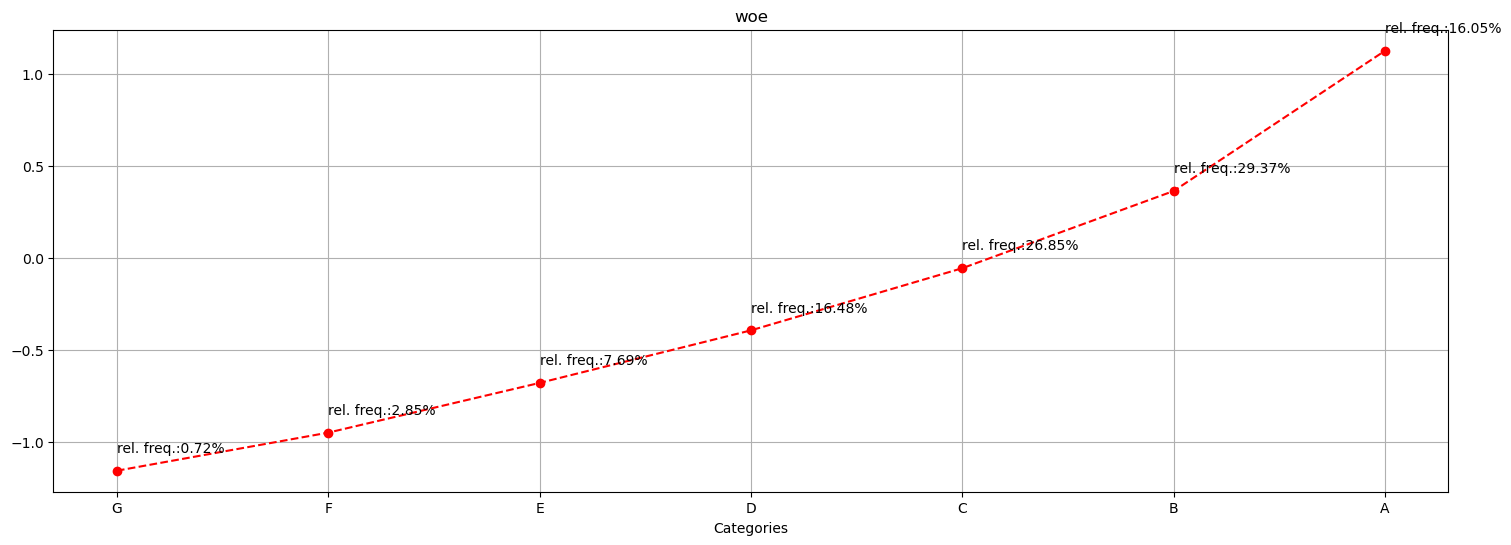

In [406]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [407]:
grade_groups.add_child(Group(is_reference=True).extend_group(['G', 'F', 'E']))

In [408]:
grade_groups.add_one_category_groups(['D', 'C', 'B', 'A'])

In [409]:
print(grade_groups)

|----grade
|	|----G_F_E***
|	|	|----G
|	|	|----F
|	|	|----E
|	|----D
|	|	|----D
|	|----C
|	|	|----C
|	|----B
|	|	|----B
|	|----A
|	|	|----A



In [410]:
dft.add_child(grade_groups)

**Home ownership**

In [412]:
owner_groups = GroupedColumn('home_ownership')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

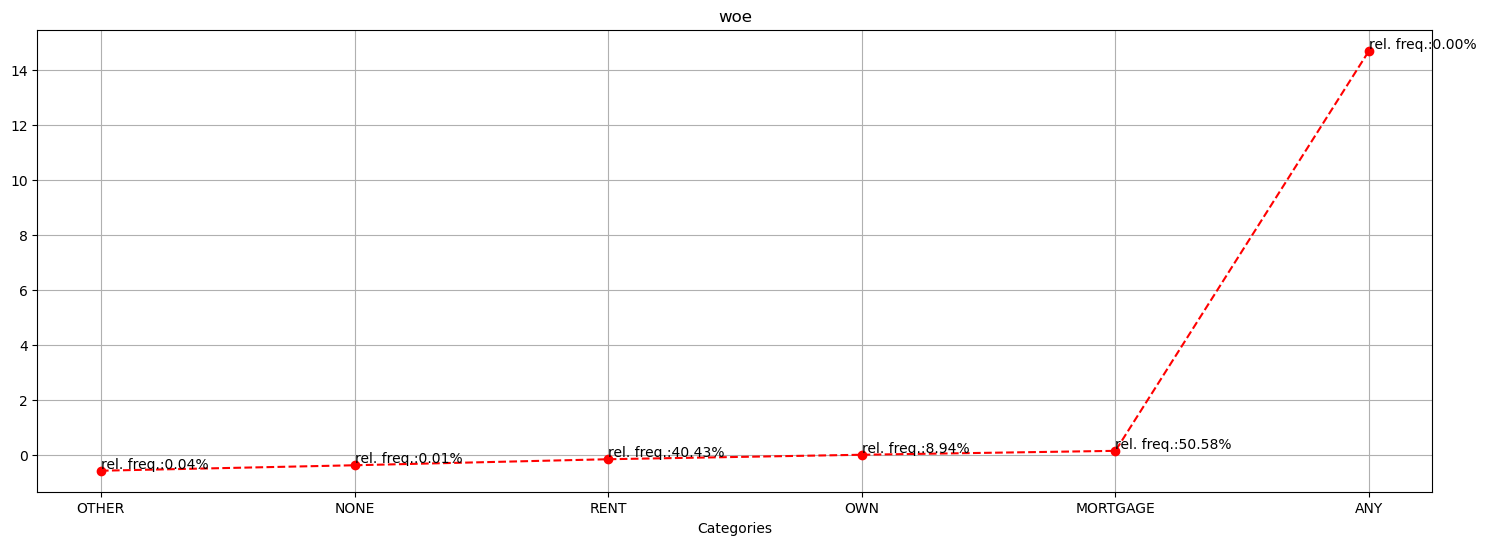

In [413]:
plot_woe(woe_summary.loc['home_ownership', :]['woe'], labels=woe_summary.loc['home_ownership', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [414]:
under_represented_n_risky = Group().add_child('OTHER').add_child('NONE').add_child('ANY').add_child('RENT')

In [415]:
owner_groups.add_child(under_represented_n_risky)

In [416]:
owner_groups.add_one_category_groups(['OWN', 'MORTGAGE'])

In [417]:
dft.add_child(owner_groups)
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E***
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE



**State**

In [418]:
states_groups = GroupedColumn('addr_state')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

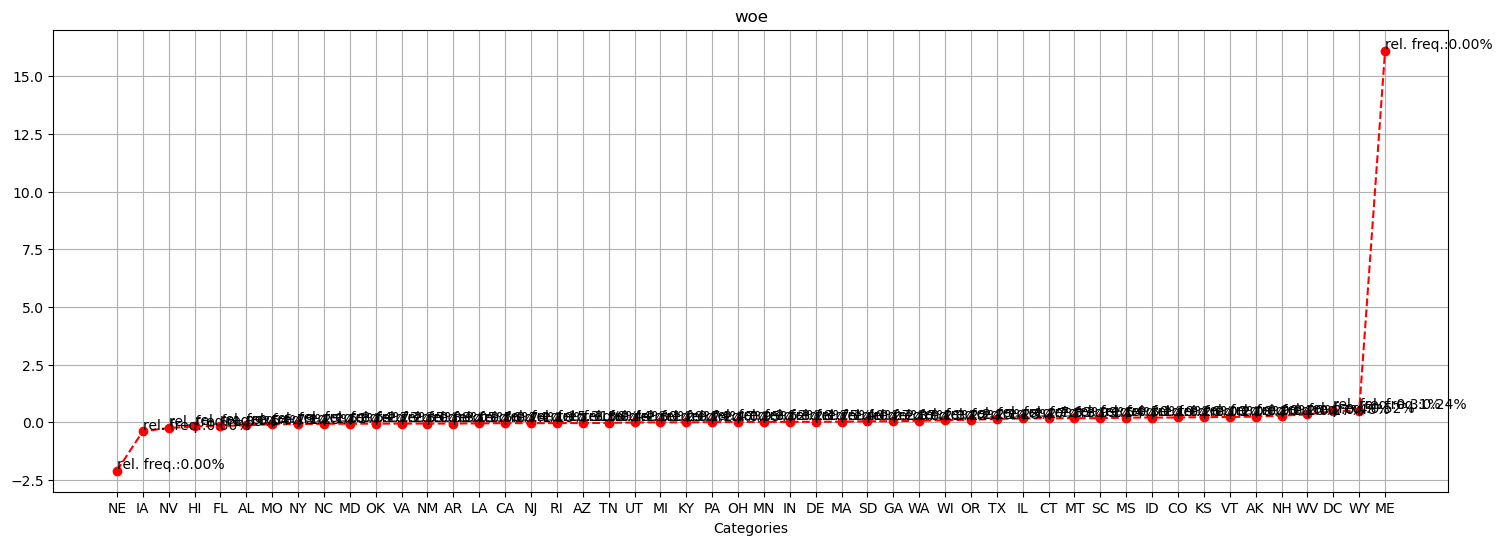

In [419]:
plot_woe(woe_summary.loc['addr_state', :]['woe'], labels=woe_summary.loc['addr_state', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [420]:
woe_summary.loc['addr_state', :]

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
NE,6,6,12,0.000029,1.308016e-04,0.000016,-2.097848,NaN,NaN,NaN,0.000029,0.01244
IA,2,11,13,0.000031,4.360053e-05,0.000029,-0.393100,0.000013,0.000087,1.704748,0.000060,0.01244
NV,792,5052,5844,0.013926,1.726581e-02,0.013516,-0.244870,0.013486,0.017222,0.148230,0.013985,0.01244
HI,288,1958,2246,0.005352,6.278477e-03,0.005238,-0.181129,0.008277,0.010987,0.063740,0.019337,0.01244
FL,3581,24897,28478,0.067860,7.806675e-02,0.066608,-0.158742,0.061370,0.071788,0.022387,0.087198,0.01244
AL,645,4610,5255,0.012522,1.406117e-02,0.012333,-0.131115,0.054275,0.064006,0.027628,0.099720,0.01244
MO,795,5958,6753,0.016092,1.733121e-02,0.015940,-0.083700,0.003606,0.003270,0.047415,0.115812,0.01244
NY,4250,32003,36253,0.086387,9.265113e-02,0.085619,-0.078937,0.069679,0.075320,0.004763,0.202199,0.01244
NC,1323,10125,11448,0.027279,2.884175e-02,0.027088,-0.062742,0.058531,0.063809,0.016195,0.229478,0.01244
MD,1141,8740,9881,0.023545,2.487410e-02,0.023382,-0.061843,0.003705,0.003968,0.000899,0.253024,0.01244


In [421]:
len(woe_summary.loc['addr_state', :])

50

<Axes: title={'center': 'woe'}, xlabel='Categories'>

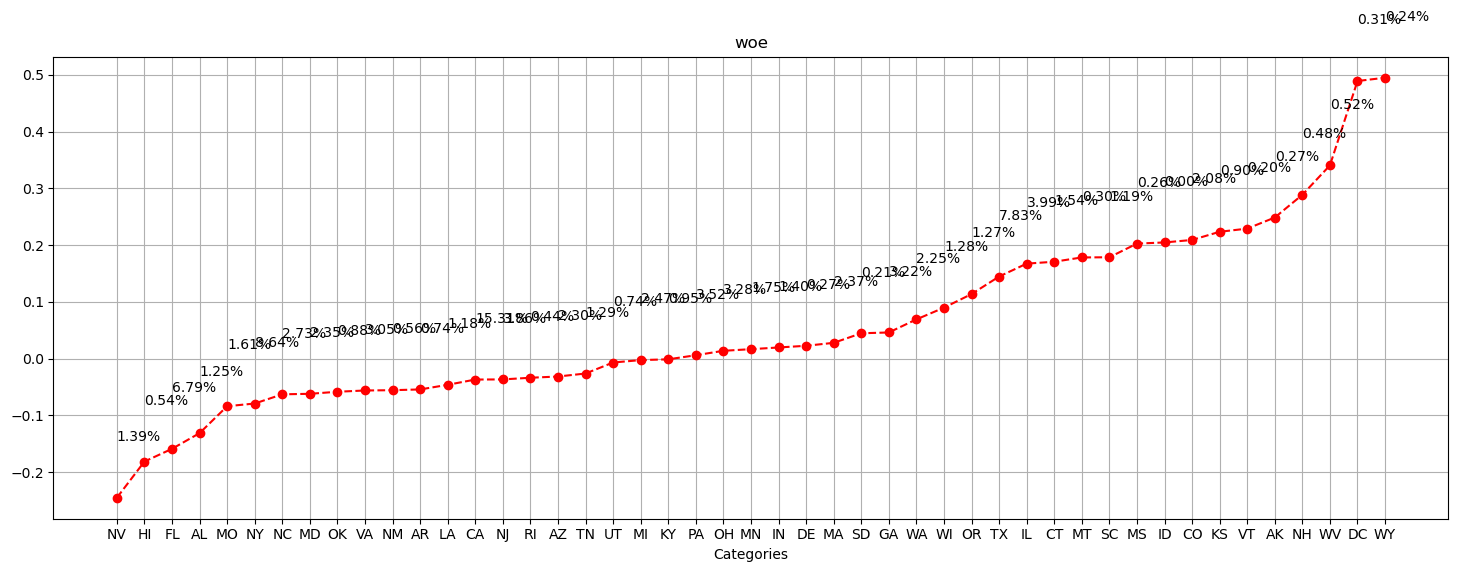

In [422]:
plot_woe(woe_summary.loc['addr_state', :].iloc[2:-1, :]['woe'],
         labels=woe_summary.loc['addr_state', :].iloc[2:-1, :]['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [423]:
states_groups.add_child(Group().extend_group(['NE', 'IA', 'ND', 'NV', 'HI', 'FL', 'AL']))\
            .add_child(Group().extend_group(['ID', 'NH', 'WV', 'WY', 'DC', 'ME'])) #best and underrepresented

<Axes: title={'center': 'woe'}, xlabel='Categories'>

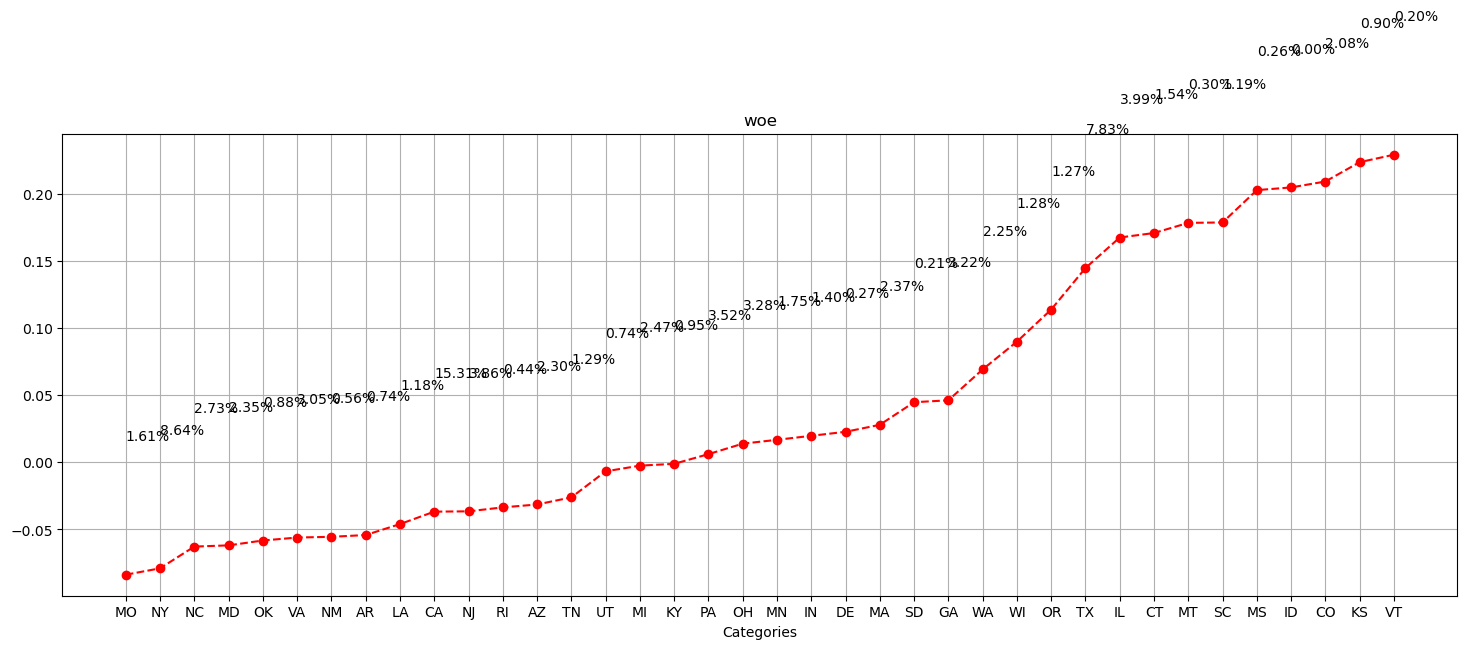

In [424]:
plot_woe(woe_summary.loc['addr_state', :].iloc[6:-6, :]['woe'],
         labels=woe_summary.loc['addr_state', :].iloc[6:-6, :]['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [425]:
states_groups.add_child(Group().add_child('NY')).add_child(Group().add_child('CA'))

In [426]:
states_groups.add_child(Group().extend_group(['NM', 'OK', 'NC', 'MO', 'MD', 'NJ', 'VA']))

In [427]:
states_groups.add_child(Group().extend_group(['AZ', 'MI', 'UT', 'TN', 'AR', 'PA']))\
            .add_child(Group().extend_group(['RI', 'OH', 'KY', 'DE', 'MN', 'SD', 'MA', 'IN']))          

In [428]:
states_groups.add_child(Group().extend_group(['GA', 'WA', 'WI', 'OR']))\
              .add_child(Group().add_child('TX'))

In [429]:
states_groups.add_child(Group().extend_group(['IL', 'MT', 'CT']))\
            .add_child(Group().extend_group(['MT', 'CO', 'SC', 'KS', 'VT', 'AK', 'MS']))

In [430]:
dft.add_child(states_groups)

In [431]:
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E***
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE
|	|----addr_state
|	|	|----NE_IA_ND_NV_HI_FL_AL
|	|	|	|----NE
|	|	|	|----IA
|	|	|	|----ND
|	|	|	|----NV
|	|	|	|----HI
|	|	|	|----FL
|	|	|	|----AL
|	|	|----ID_NH_WV_WY_DC_ME
|	|	|	|----ID
|	|	|	|----NH
|	|	|	|----WV
|	|	|	|----WY
|	|	|	|----DC
|	|	|	|----ME
|	|	|----NY
|	|	|	|----NY
|	|	|----CA
|	|	|	|----CA
|	|	|----NM_OK_NC_MO_MD_NJ_VA
|	|	|	|----NM
|	|	|	|----OK
|	|	|	|----NC
|	|	|	|----MO
|	|	|	|----MD
|	|	|	|----NJ
|	|	|	|----VA
|	|	|----AZ_MI_UT_TN_AR_PA
|	|	|	|----AZ
|	|	|	|----MI
|	|	|	|----UT
|	|	|	|----TN
|	|	|	|----AR
|	|	|	|----PA
|	|	|----RI_OH_KY_DE_MN_SD_MA_IN
|	|	|	|----RI
|	|	|	|----OH
|	|	|	|----KY
|	|	|	

**Verification status**

In [432]:
verification_groups = GroupedColumn('verification_status')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

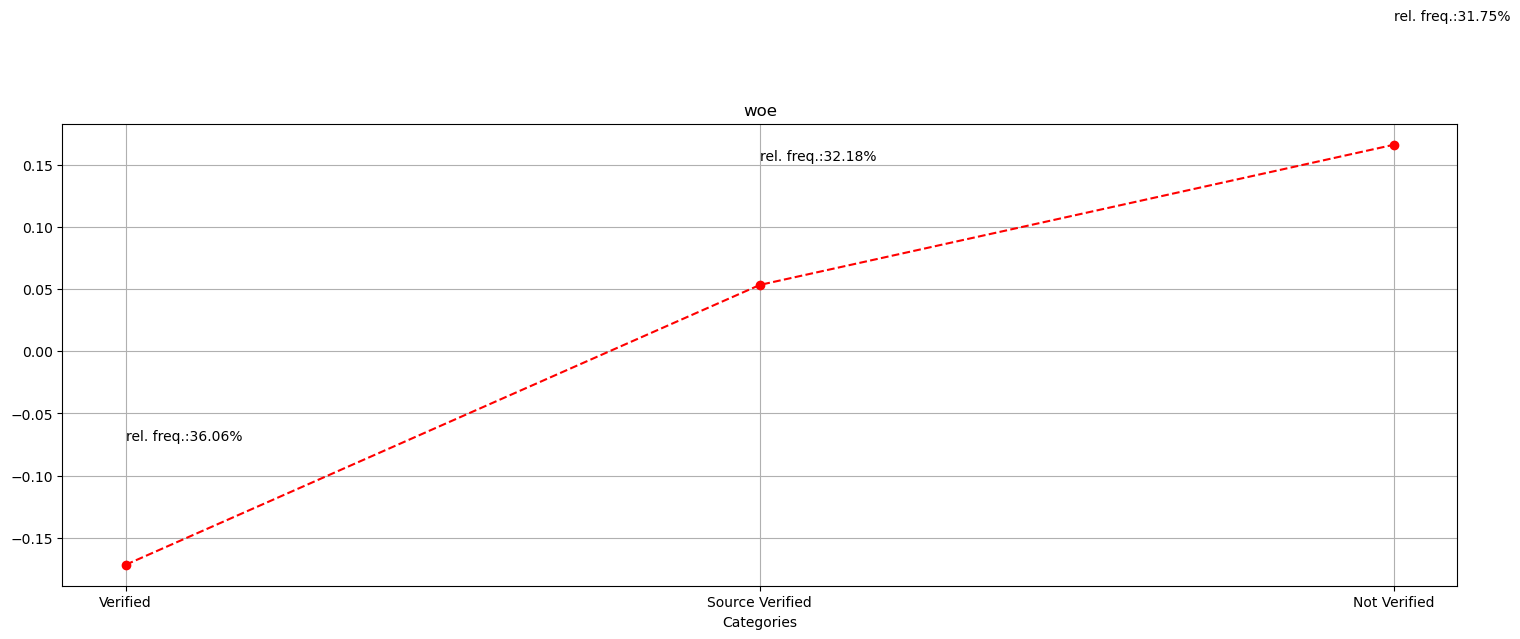

In [433]:
plot_woe(woe_summary.loc['verification_status', :]['woe'], labels=woe_summary.loc['verification_status', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [434]:
verification_groups.add_one_category_groups(woe_summary.loc['verification_status', :].index.to_list())

In [435]:
dft.add_child(verification_groups)

**Purpose**

In [436]:
purpose_groups = GroupedColumn('purpose')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

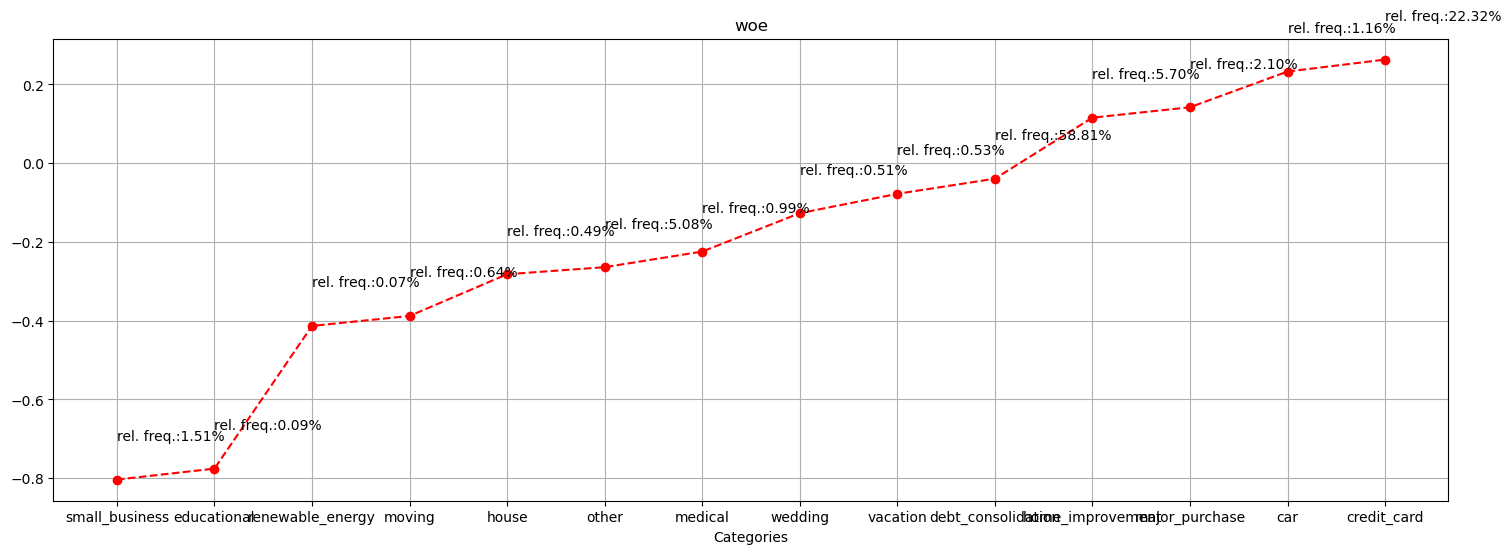

In [437]:
plot_woe(woe_summary.loc['purpose', :]['woe'], labels=woe_summary.loc['purpose', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [438]:
purpose_groups.add_child(
        Group().extend_group(['educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house', 'other', 'medical', 'vacation'])
    ).add_child(
        Group().add_child('debt_consolidation')
    ).add_child(
        Group().extend_group(['major_purchase', 'car', 'home_improvement'])
    ).add_child(
        Group().add_child('credit_card')
    )

In [439]:
dft.add_child(purpose_groups)

**Initial List status**

In [440]:
initial_list_groups = GroupedColumn('initial_list_status')

In [441]:
woe_summary.loc['initial_list_status', :].head()

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
f,32820,239953,272773,0.649992,0.715485,0.641955,-0.108443,NaN,NaN,NaN,0.649992,0.024876
w,13051,133832,146883,0.350008,0.284515,0.358045,0.229873,0.283909,0.430969,0.338316,1.000000,0.024876


In [442]:
initial_list_groups.add_one_category_groups(['f', 'w'])

In [443]:
print(initial_list_groups)

|----initial_list_status
|	|----f
|	|	|----f
|	|----w
|	|	|----w



In [444]:
dft.add_child(initial_list_groups)

In [445]:
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E***
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE
|	|----addr_state
|	|	|----NE_IA_ND_NV_HI_FL_AL
|	|	|	|----NE
|	|	|	|----IA
|	|	|	|----ND
|	|	|	|----NV
|	|	|	|----HI
|	|	|	|----FL
|	|	|	|----AL
|	|	|----ID_NH_WV_WY_DC_ME
|	|	|	|----ID
|	|	|	|----NH
|	|	|	|----WV
|	|	|	|----WY
|	|	|	|----DC
|	|	|	|----ME
|	|	|----NY
|	|	|	|----NY
|	|	|----CA
|	|	|	|----CA
|	|	|----NM_OK_NC_MO_MD_NJ_VA
|	|	|	|----NM
|	|	|	|----OK
|	|	|	|----NC
|	|	|	|----MO
|	|	|	|----MD
|	|	|	|----NJ
|	|	|	|----VA
|	|	|----AZ_MI_UT_TN_AR_PA
|	|	|	|----AZ
|	|	|	|----MI
|	|	|	|----UT
|	|	|	|----TN
|	|	|	|----AR
|	|	|	|----PA
|	|	|----RI_OH_KY_DE_MN_SD_MA_IN
|	|	|	|----RI
|	|	|	|----OH
|	|	|	|----KY
|	|	|	

In [447]:
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E***
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE
|	|----addr_state
|	|	|----NE_IA_ND_NV_HI_FL_AL
|	|	|	|----NE
|	|	|	|----IA
|	|	|	|----ND
|	|	|	|----NV
|	|	|	|----HI
|	|	|	|----FL
|	|	|	|----AL
|	|	|----ID_NH_WV_WY_DC_ME
|	|	|	|----ID
|	|	|	|----NH
|	|	|	|----WV
|	|	|	|----WY
|	|	|	|----DC
|	|	|	|----ME
|	|	|----NY
|	|	|	|----NY
|	|	|----CA
|	|	|	|----CA
|	|	|----NM_OK_NC_MO_MD_NJ_VA
|	|	|	|----NM
|	|	|	|----OK
|	|	|	|----NC
|	|	|	|----MO
|	|	|	|----MD
|	|	|	|----NJ
|	|	|	|----VA
|	|	|----AZ_MI_UT_TN_AR_PA
|	|	|	|----AZ
|	|	|	|----MI
|	|	|	|----UT
|	|	|	|----TN
|	|	|	|----AR
|	|	|	|----PA
|	|	|----RI_OH_KY_DE_MN_SD_MA_IN
|	|	|	|----RI
|	|	|	|----OH
|	|	|	|----KY
|	|	|	

#### Continuous Variables

In [65]:
BINS = 50

In [452]:
continuous_vars: List[str] = [
    'term_int',
    'non_default',
    'emp_length_int',
    'months_since_issue_d',
    'int_rate',
    'funded_amnt',
    'months_since_earliest_cr_line',
    'installment',
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'annual_inc',
    'dti',
    'mths_since_last_record'
]

In [453]:
continuous_df: pd.DataFrame = df[continuous_vars].copy()

In [454]:
continuous_dft = DataFrameTransform()

**Term int**

In [156]:
calculate_woe_iv(continuous_df, continuous_df['term_int'], continuous_df['non_default'], multilevel_index=False, sort_by_woe=False)

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
term_int,,,,,,,,,,,,
36,32810,305143,337953,0.724778,0.643737,0.734723,0.132203,NaN,NaN,NaN,0.724778,0.03886
60,18158,110174,128332,0.275222,0.356263,0.265277,-0.294894,0.469446,0.287474,0.427097,1.000000,0.03886


In [157]:
term_int_groups: GroupedColumn = GroupedColumn('term_int').add_one_category_groups(continuous_df['term_int'].unique().tolist())

In [158]:
continuous_dft.add_child(term_int_groups)

**Emp length int**

In [159]:
emp_length_groups = GroupedColumn('emp_length_int')

In [160]:
continuous_df['emp_length_int'].unique()

array([ 0,  2, 10,  9,  1,  3,  6,  8,  7,  4,  5], dtype=int8)

In [161]:
emp_length_woe = calculate_woe_iv(continuous_df, continuous_df['emp_length_int'], continuous_df['non_default'], multilevel_index=False, sort_by_woe=False)

In [162]:
emp_length_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
emp_length_int,,,,,,,,,,,,
0,7101,50172,57273,0.122828,0.139323,0.120804,-0.142623,NaN,NaN,NaN,0.122828,0.006611
1,3314,26308,29622,0.063528,0.065021,0.063344,-0.026127,0.057460,0.074302,0.116496,0.186356,0.006611
2,4541,36832,41373,0.088729,0.089095,0.088684,-0.004624,0.025340,0.024074,0.021503,0.275085,0.006611
3,4008,32588,36596,0.078484,0.078638,0.078465,-0.002192,0.010219,0.010458,0.002432,0.353569,0.006611
4,3071,24952,28023,0.060098,0.060253,0.060079,-0.002893,0.018386,0.018384,0.000701,0.413668,0.006611
5,3538,27236,30774,0.065998,0.069416,0.065579,-0.056866,0.005499,0.009163,0.053973,0.479666,0.006611
6,3058,23054,26112,0.056000,0.059998,0.055509,-0.077766,0.010069,0.009418,0.020900,0.535666,0.006611
7,2915,23265,26180,0.056146,0.057193,0.056017,-0.020764,0.000508,0.002806,0.057002,0.591812,0.006611
8,2465,19930,22395,0.048029,0.048364,0.047987,-0.007810,0.008030,0.008829,0.012954,0.639840,0.006611


<Axes: title={'center': 'woe'}, xlabel='Categories'>

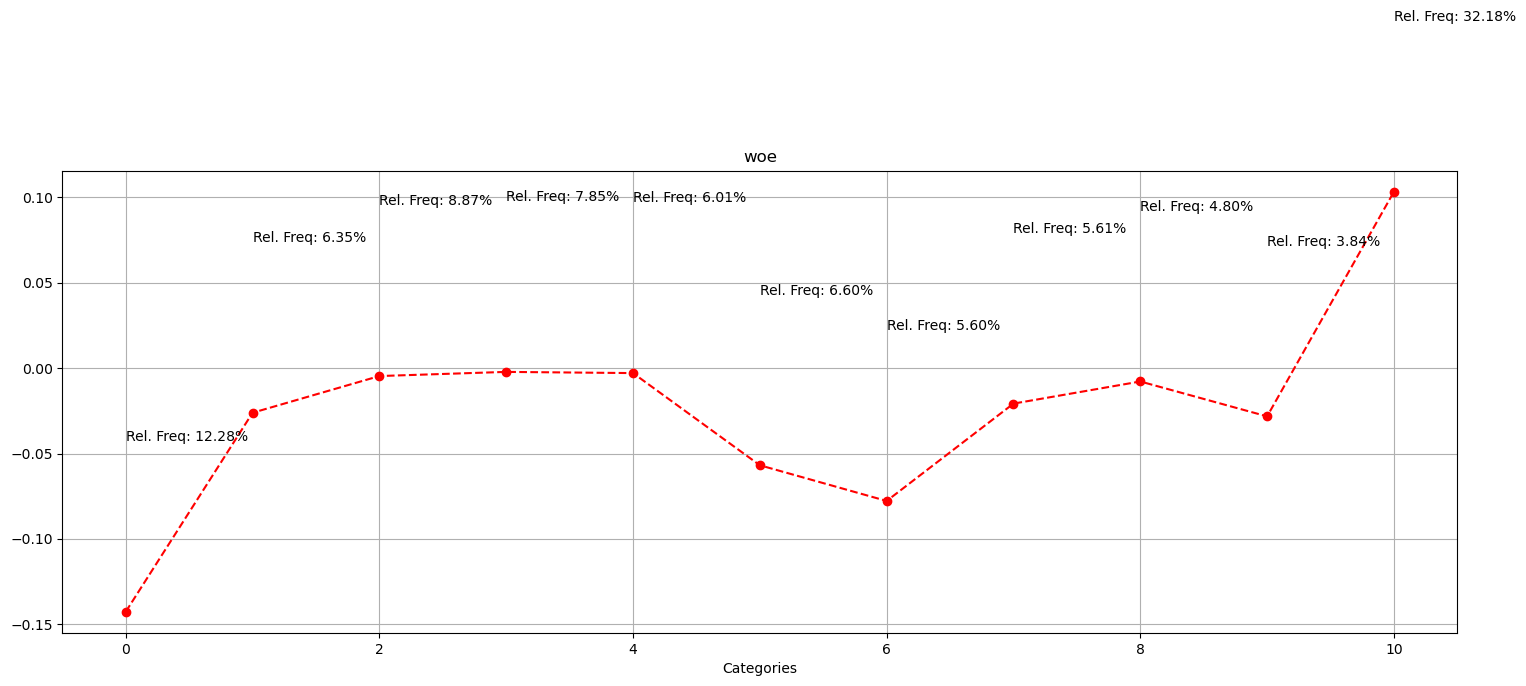

In [163]:
plot_woe(emp_length_woe['woe'], labels=emp_length_woe['n_obs_rel'].apply(lambda v: 'Rel. Freq: {:.2%}'.format(v)))

In [164]:
emp_length_groups.add_child(
        Group().add_child(0)
    ).add_child(
        Group().add_child(1)
    ).add_child(
        Group().extend_group([2, 3, 4])
    ).add_child(
        Group().extend_group([5, 6])
    ).add_child(
        Group().extend_group([7, 8, 9])
    ).add_child(
        Group().add_child(10)
    )

In [165]:
print(emp_length_groups)

|----emp_length_int
|	|----0
|	|	|----0
|	|----1
|	|	|----1
|	|----2_3_4
|	|	|----2
|	|	|----3
|	|	|----4
|	|----5_6
|	|	|----5
|	|	|----6
|	|----7_8_9
|	|	|----7
|	|	|----8
|	|	|----9
|	|----10
|	|	|----10



In [166]:
continuous_dft.add_child(emp_length_groups)

**Months since issue date**

In [167]:
m_issue_groups = GroupedColumn('months_since_issue_d')

In [168]:
msid_woe = calculate_woe_iv(
                continuous_df,
                pd.cut(continuous_df['months_since_issue_d'], bins=BINS, retbins=False),
                continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

<Axes: title={'center': 'woe'}, xlabel='Categories'>

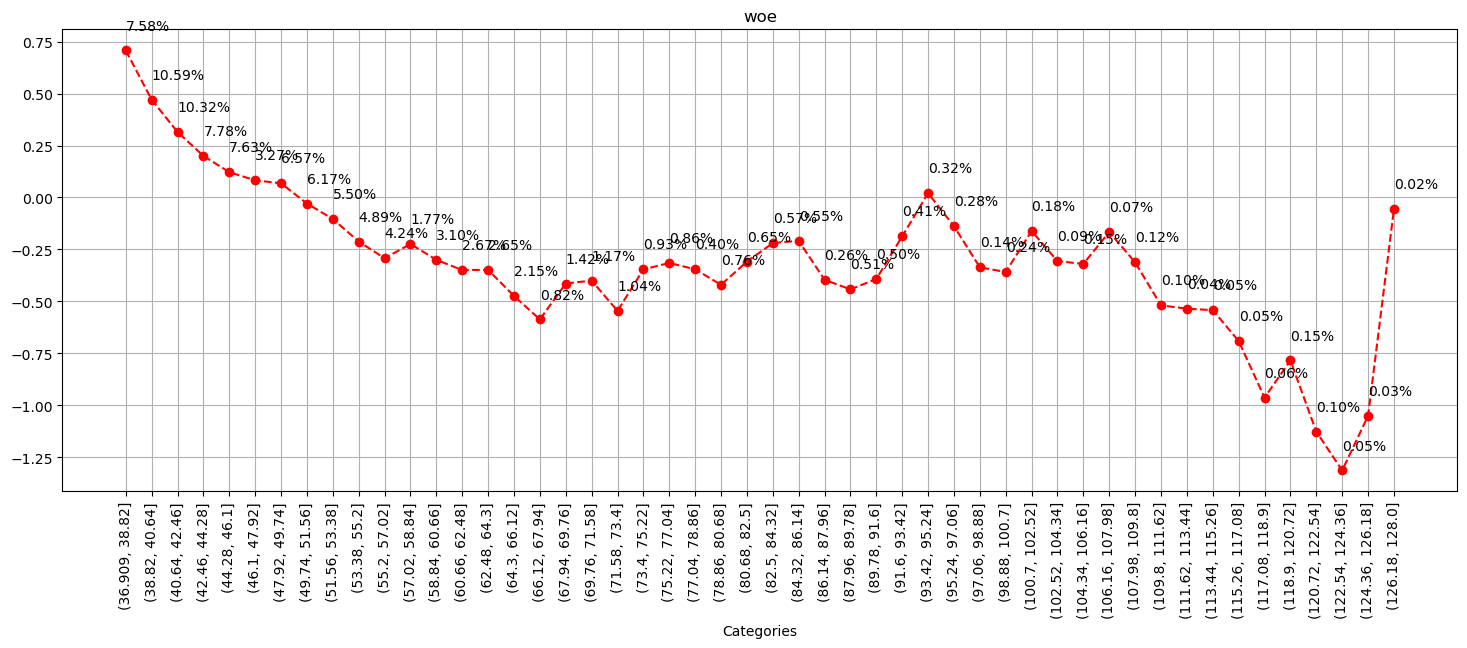

In [169]:
plot_woe(msid_woe['woe'], labels=msid_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [170]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=38, closed='right'))
    )

In [171]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=38, right=40, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=40, right=42, closed='right'))
    )

<Axes: title={'center': 'woe'}, xlabel='Categories'>

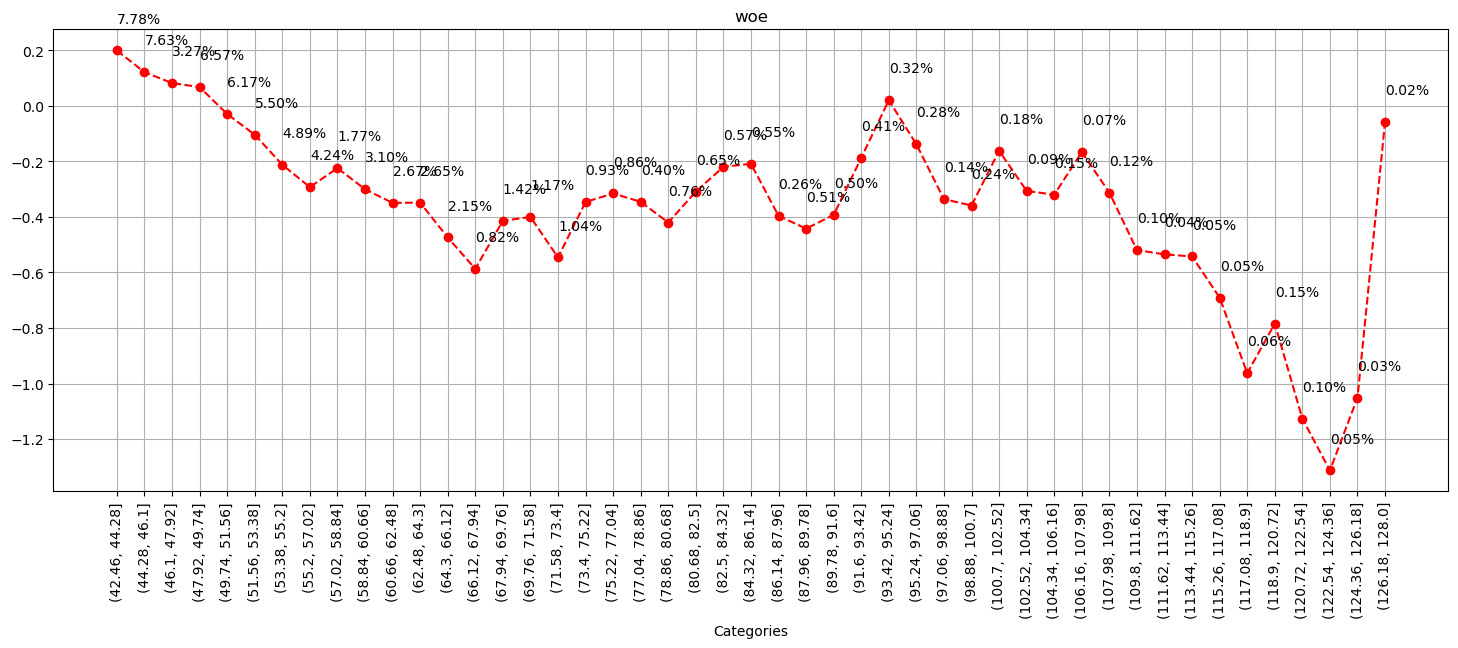

In [172]:
plot_woe(msid_woe['woe'].iloc[3:], labels=msid_woe['n_obs_rel'].iloc[3:].apply(lambda v: '{:.2%}'.format(v)))

In [173]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=42, right=49, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=49, right=53, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=53, right=64, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=64, right=86, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=86, right=np.inf, closed='right'))
    )

In [174]:
continuous_dft.add_child(m_issue_groups)

**Interest rate**

In [175]:
int_rate_groups = GroupedColumn('int_rate')

In [176]:
int_rate_woe = calculate_woe_iv(
                continuous_df,
                pd.cut(continuous_df['int_rate'], bins=BINS, retbins=False),
                continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [177]:
int_rate_woe.head()

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
int_rate,,,,,,,,,,,,
"(5.399, 5.833]",36,947,983,0.002108,0.000706,0.002280,1.171936,NaN,NaN,NaN,0.002108,0.347385
"(5.833, 6.246]",208,10337,10545,0.022615,0.004081,0.024889,1.808103,0.022609,0.003375,0.636167,0.024723,0.347385
"(6.246, 6.658]",278,9522,9800,0.021017,0.005454,0.022927,1.435895,0.001962,0.001373,0.372208,0.045740,0.347385
"(6.658, 7.071]",72,2221,2293,0.004918,0.001413,0.005348,1.331203,0.017579,0.004042,0.104692,0.050658,0.347385
"(7.071, 7.484]",89,3858,3947,0.008465,0.001746,0.009289,1.671424,0.003942,0.000334,0.340221,0.059123,0.347385


<Axes: title={'center': 'woe'}, xlabel='Categories'>

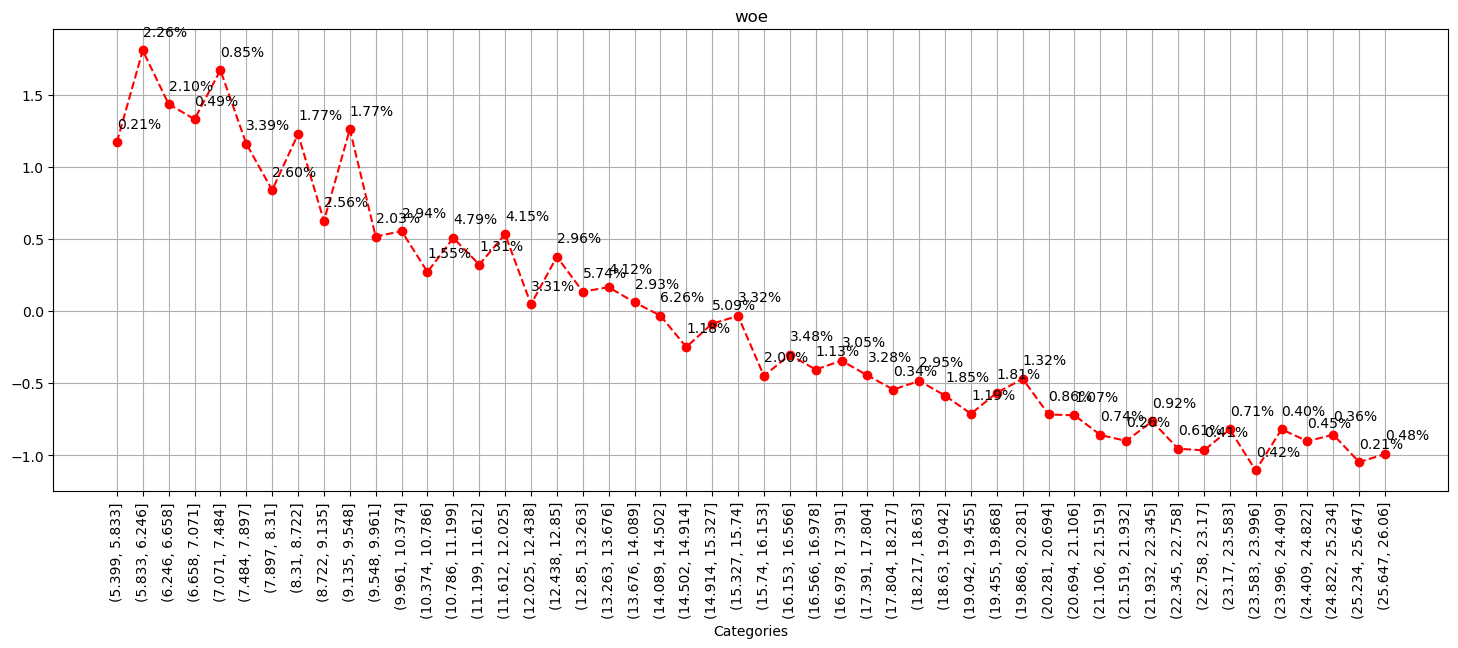

In [178]:
plot_woe(int_rate_woe['woe'], labels=int_rate_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [179]:
int_rate_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=9.548, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=9.548, right=12.025, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=12.025, right=15.74, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=15.74, right=20.281, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=20.281, right=np.inf, closed='right'))
    )

In [180]:
continuous_dft.add_child(int_rate_groups)

**Funded amount**

In [181]:
funded_amnt_groups = GroupedColumn('funded_amnt')

In [182]:
funded_amnt_woe = calculate_woe_iv(
                continuous_df,
                pd.cut(continuous_df['funded_amnt'], bins=BINS, retbins=False),
                continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

<Axes: title={'center': 'woe'}, xlabel='Categories'>

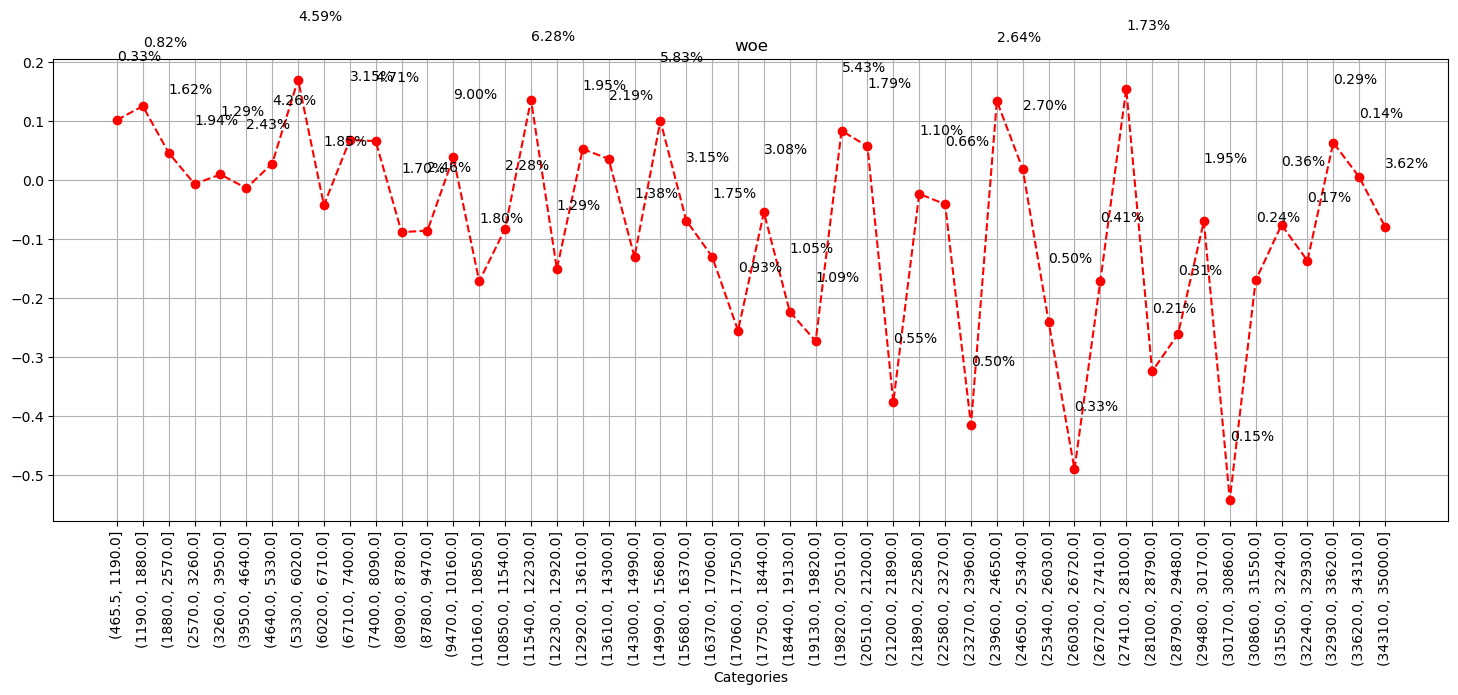

In [183]:
plot_woe(funded_amnt_woe['woe'], labels=funded_amnt_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

**Volatile behaviour around a flat trend**: do not use the variable in the model!

**months_since_earliest_cr_line**

In [184]:
earliest_cr_groups = GroupedColumn('months_since_earliest_cr_line')

In [185]:
earliest_cr_woe = calculate_woe_iv(
                continuous_df,
                pd.cut(continuous_df['months_since_earliest_cr_line'], bins=BINS, retbins=False),
                continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [186]:
earliest_cr_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
months_since_earliest_cr_line,,,,,,,,,,,,
"(-0.9, 18.0]",3,26,29,0.000062,5.886046e-05,0.000063,0.061640,NaN,NaN,NaN,0.000062,0.01653
"(72.0, 90.0]",243,2253,2496,0.005353,4.767697e-03,0.005425,0.129112,0.005362,0.004709,0.067472,0.005415,0.01653
"(90.0, 108.0]",650,4005,4655,0.009983,1.275310e-02,0.009643,-0.279518,0.004218,0.007985,0.408630,0.015398,0.01653
"(108.0, 126.0]",1657,10867,12524,0.026859,3.251059e-02,0.026166,-0.217122,0.016522,0.019757,0.062395,0.042257,0.01653
"(126.0, 144.0]",2945,19071,22016,0.047216,5.778135e-02,0.045919,-0.229784,0.019754,0.025271,0.012662,0.089473,0.01653
"(144.0, 162.0]",3403,24754,28157,0.060386,6.676738e-02,0.059603,-0.113514,0.013684,0.008986,0.116270,0.149859,0.01653
"(162.0, 180.0]",3839,28967,32806,0.070356,7.532177e-02,0.069747,-0.076899,0.010144,0.008554,0.036616,0.220215,0.01653
"(180.0, 198.0]",5074,39384,44458,0.095345,9.955266e-02,0.094829,-0.048614,0.025082,0.024231,0.028285,0.315560,0.01653
"(198.0, 216.0]",6019,46511,52530,0.112656,1.180937e-01,0.111989,-0.053076,0.017160,0.018541,0.004462,0.428217,0.01653


<Axes: title={'center': 'woe'}, xlabel='Categories'>

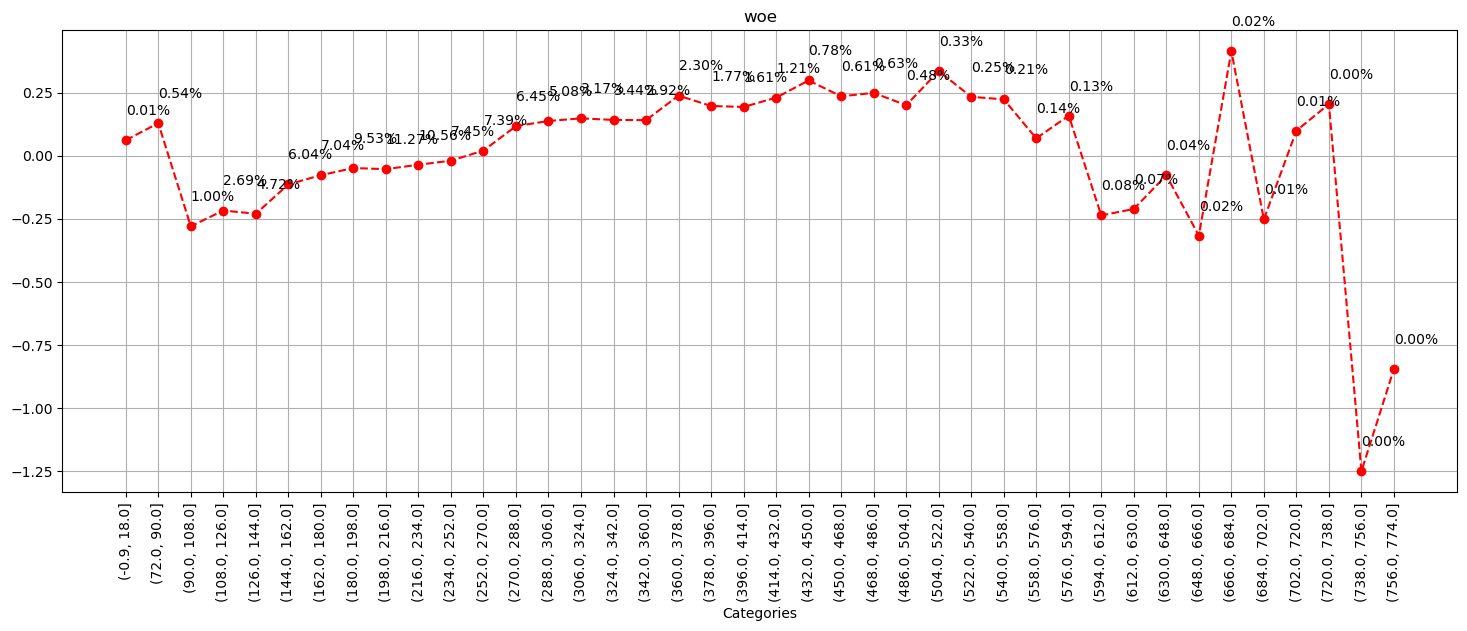

In [187]:
plot_woe(earliest_cr_woe['woe'][:-7], labels=earliest_cr_woe['n_obs_rel'][:-7].apply(lambda v: '{:.2%}'.format(v)))

In [188]:
earliest_cr_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=144, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=414, right=np.inf, closed='right'))
    )

<Axes: title={'center': 'woe'}, xlabel='Categories'>

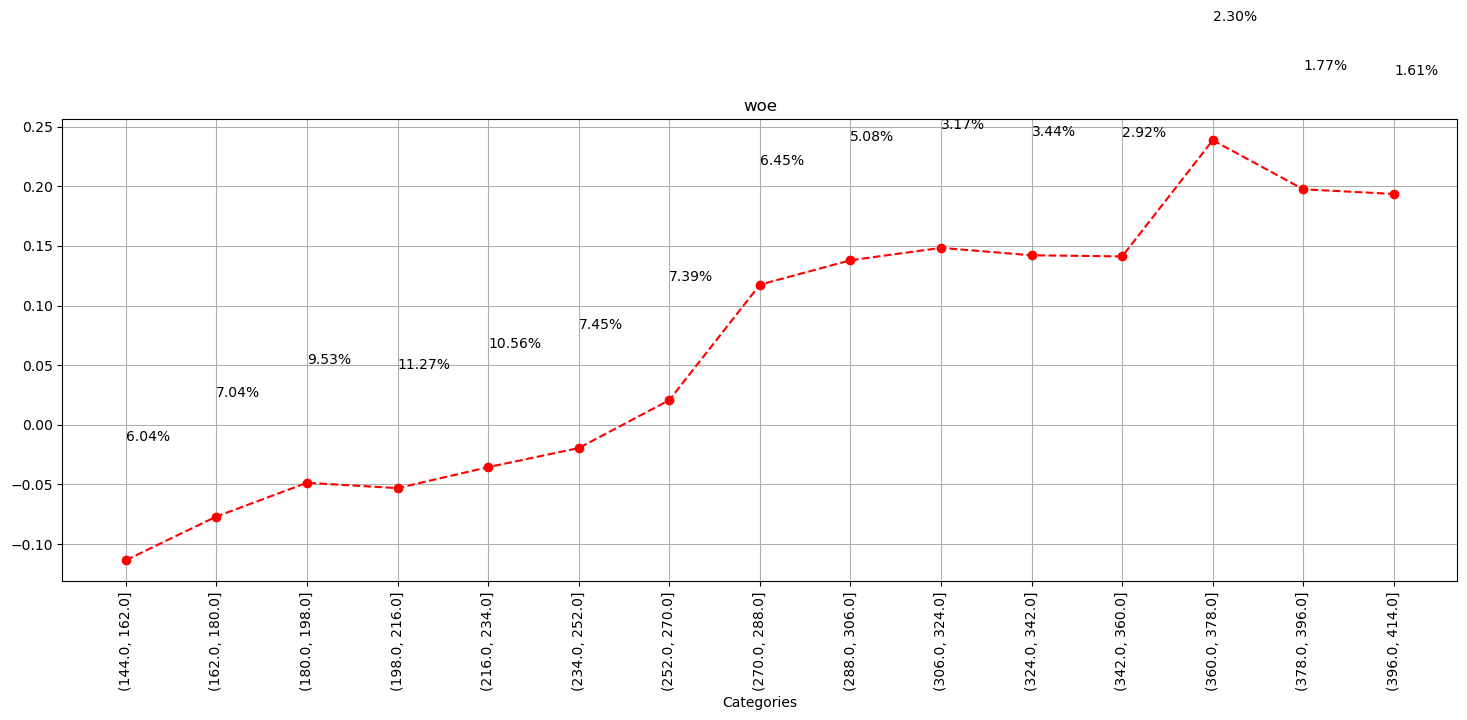

In [189]:
plot_woe(earliest_cr_woe['woe'][5:20], labels=earliest_cr_woe['n_obs_rel'][5:20].apply(lambda v: '{:.2%}'.format(v)))

In [190]:
earliest_cr_groups.add_child(
        Interval().add_child(pd.Interval(left=360, right=414, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=270, right=360, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=270, right=360, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=144, right=162, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=162, right=180, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=180, right=216, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=216, right=252, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=252, right=270, closed='right'))
    )

In [191]:
continuous_dft.add_child(earliest_cr_groups)

**installment**

In [192]:
installment_groups = GroupedColumn('installment')

In [193]:
installment_woe = calculate_woe_iv(
                    continuous_df,
                    pd.cut(continuous_df['installment'], bins=BINS, retbins=False),
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

<Axes: title={'center': 'woe'}, xlabel='Categories'>

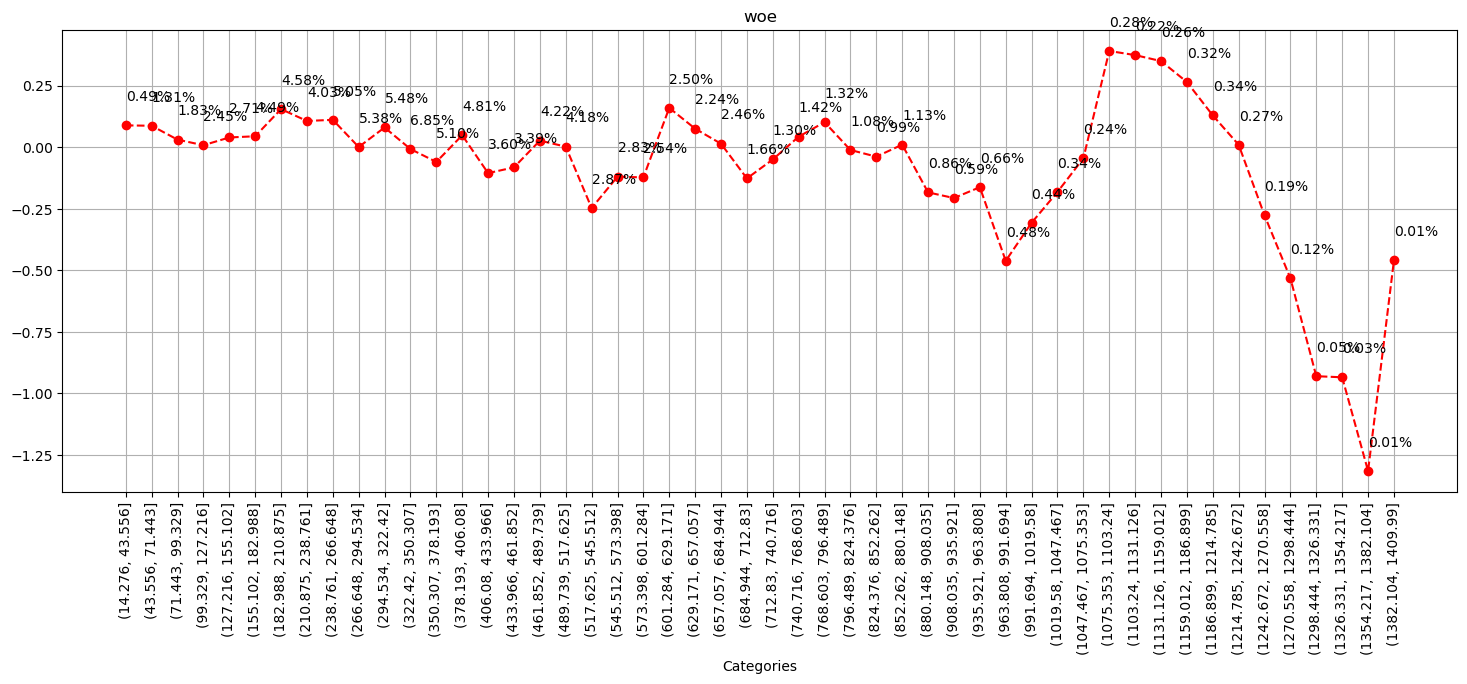

In [194]:
plot_woe(installment_woe['woe'], labels=installment_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

**Volatile**: do not use!

**delinq_2yrs**

In [195]:
delinq_2yrs_groups = GroupedColumn('delinq_2yrs')

In [196]:
delinq_2yrs_woe = calculate_woe_iv(
                    continuous_df,
                    pd.cut(continuous_df['delinq_2yrs'], bins=BINS, retbins=False),
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [197]:
delinq_2yrs_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
delinq_2yrs,,,,,,,,,,,,
"(-0.029, 0.58]",41903,341080,382983,0.821350,8.221433e-01,0.821252,-0.001084,NaN,NaN,NaN,0.821350,0.0009
"(0.58, 1.16]",6034,50190,56224,0.120579,1.183880e-01,0.120847,0.020562,0.700405,0.703755,0.021646,0.941928,0.0009
"(1.74, 2.32]",1823,14487,16310,0.034979,3.576754e-02,0.034882,-0.025076,0.085966,0.082620,0.045637,0.976907,0.0009
"(2.9, 3.48]",652,5032,5684,0.012190,1.279234e-02,0.012116,-0.054316,0.022766,0.022975,0.029240,0.989097,0.0009
"(3.48, 4.06]",247,2131,2378,0.005100,4.846178e-03,0.005131,0.057114,0.006985,0.007946,0.111430,0.994197,0.0009
"(4.64, 5.22]",138,1098,1236,0.002651,2.707581e-03,0.002644,-0.023852,0.002487,0.002139,0.080966,0.996847,0.0009
"(5.8, 6.38]",67,562,629,0.001349,1.314550e-03,0.001353,0.028965,0.001291,0.001393,0.052817,0.998196,0.0009
"(6.96, 7.54]",44,302,346,0.000742,8.632868e-04,0.000727,-0.171607,0.000626,0.000451,0.200572,0.998938,0.0009
"(7.54, 8.12]",17,160,177,0.000380,3.335426e-04,0.000385,0.144116,0.000342,0.000530,0.315723,0.999318,0.0009


<Axes: title={'center': 'woe'}, xlabel='Categories'>

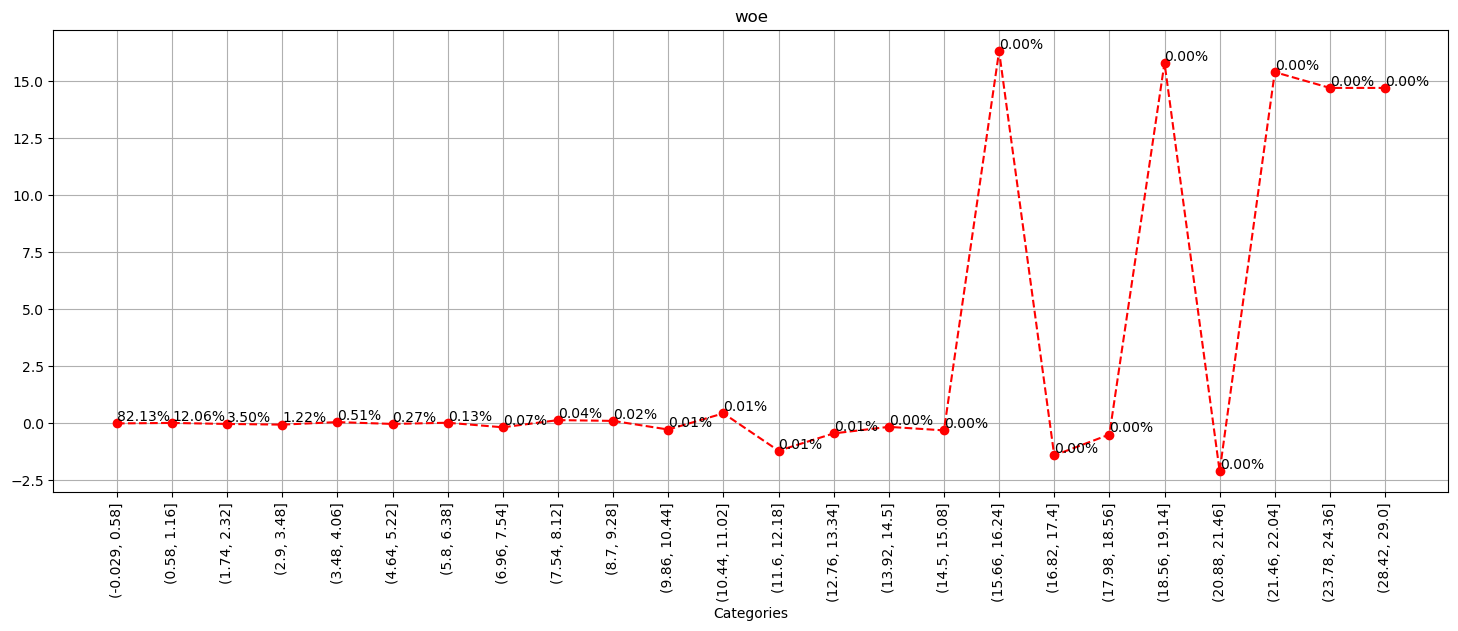

In [198]:
plot_woe(delinq_2yrs_woe['woe'], labels=delinq_2yrs_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [199]:
delinq_2yrs_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=.58, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=.58, right=1.16, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=1.16, right=np.inf, closed='right'))
    )

In [200]:
continuous_dft.add_child(delinq_2yrs_groups)

**inq_last_6mths**

In [201]:
inq_6m_groups = GroupedColumn('inq_last_6mths')

In [202]:
inq_6_groups_woe = calculate_woe_iv(
                    continuous_df,
                    pd.cut(continuous_df['inq_last_6mths'], bins=BINS, retbins=False),
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [203]:
inq_6_groups_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
inq_last_6mths,,,,,,,,,,,,
"(-0.033, 0.66]",22043,219484,241527,0.517981,4.324871e-01,5.284734e-01,0.200440,NaN,NaN,NaN,0.517981,0.05374
"(0.66, 1.32]",15040,115108,130148,0.279117,2.950871e-01,2.771570e-01,-0.062687,0.251316,0.137400,2.631267e-01,0.797098,0.05374
"(1.98, 2.64]",7887,49938,57825,0.124012,1.547442e-01,1.202407e-01,-0.252278,0.156916,0.140343,1.895911e-01,0.921110,0.05374
"(2.64, 3.3]",3995,21131,25126,0.053885,7.838251e-02,5.087921e-02,-0.432147,0.069361,0.076362,1.798688e-01,0.974996,0.05374
"(3.96, 4.62]",1108,6133,7241,0.015529,2.173913e-02,1.476703e-02,-0.386717,0.036112,0.056643,4.542986e-02,0.990525,0.05374
"(4.62, 5.28]",475,2293,2768,0.005936,9.319573e-03,5.521084e-03,-0.523543,0.009246,0.012420,1.368260e-01,0.996461,0.05374
"(5.94, 6.6]",257,931,1188,0.002548,5.042380e-03,2.241661e-03,-0.810661,0.003279,0.004277,2.871183e-01,0.999009,0.05374
"(6.6, 7.26]",68,127,195,0.000418,1.334170e-03,3.057905e-04,-1.473165,0.001936,0.003708,6.625038e-01,0.999427,0.05374
"(7.92, 8.58]",46,76,122,0.000262,9.025271e-04,1.829928e-04,-1.595752,0.000123,0.000432,1.225874e-01,0.999689,0.05374


<Axes: title={'center': 'woe'}, xlabel='Categories'>

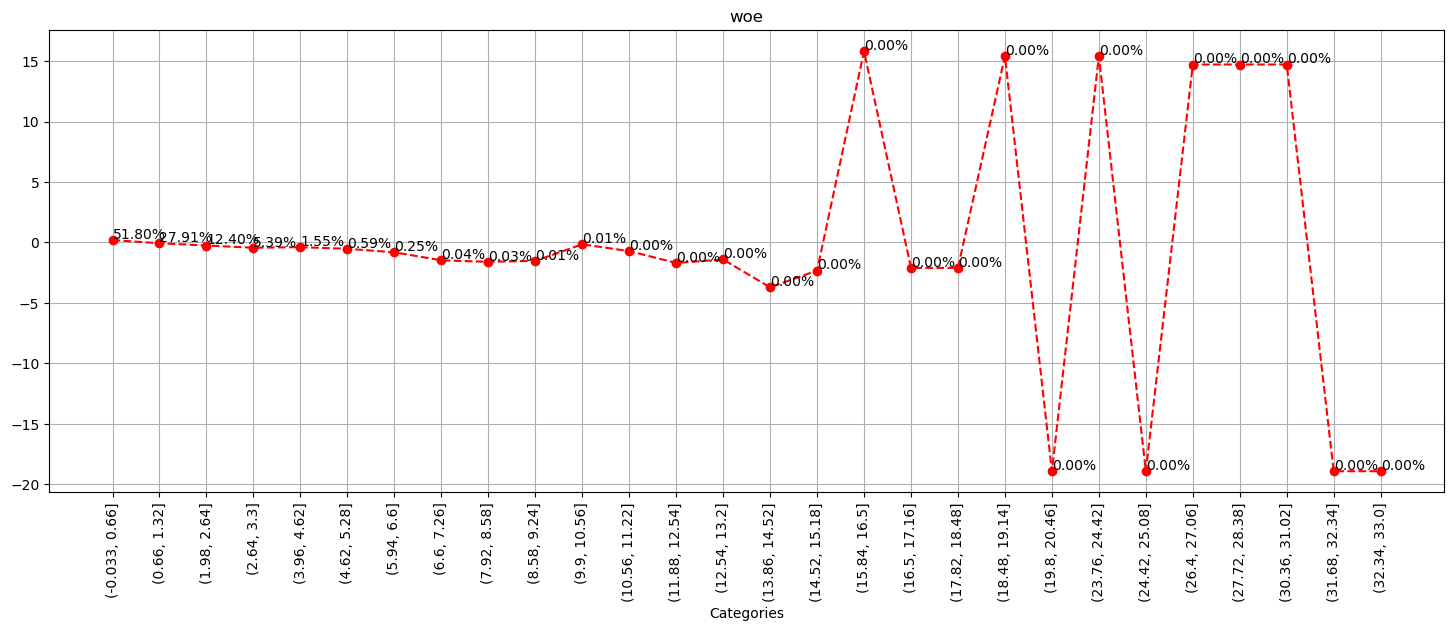

In [204]:
plot_woe(inq_6_groups_woe['woe'], labels=inq_6_groups_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [118]:
inq_6m_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=.66, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=.66, right=1.32, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=1.32, right=2.64, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=2.64, right=np.inf, closed='right'))
    )

In [119]:
continuous_dft.add_child(inq_6m_groups)

**open_acc**

In [120]:
open_acc_groups = GroupedColumn('open_acc')

In [205]:
open_acc_woe = calculate_woe_iv(
                    continuous_df,
                    pd.cut(continuous_df['open_acc'], bins=BINS, retbins=False),
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [206]:
open_acc_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
open_acc,,,,,,,,,,,,
"(-0.084, 1.68]",25,153,178,0.000382,4.905038e-04,3.683933e-04,-0.286282,NaN,NaN,NaN,0.000382,0.004241
"(1.68, 3.36]",997,6293,7290,0.015634,1.956129e-02,1.515228e-02,-0.255402,0.014784,0.019071,0.030880,0.016016,0.004241
"(3.36, 5.04]",3706,30426,34132,0.073200,7.271229e-02,7.325970e-02,0.007500,0.058107,0.053151,0.262902,0.089216,0.004241
"(5.04, 6.72]",3329,27508,30837,0.066133,6.531549e-02,6.623374e-02,0.013961,0.007026,0.007397,0.006461,0.155349,0.004241
"(6.72, 8.4]",8658,70837,79495,0.170486,1.698713e-01,1.705613e-01,0.004054,0.104328,0.104556,0.009907,0.325835,0.004241
"(8.4, 10.08]",9602,76929,86531,0.185575,1.883927e-01,1.852296e-01,-0.016933,0.014668,0.018521,0.020986,0.511410,0.004241
"(10.08, 11.76]",4396,34716,39112,0.083880,8.625020e-02,8.358916e-02,-0.031338,0.101640,0.102143,0.014406,0.595290,0.004241
"(11.76, 13.44]",6975,57416,64391,0.138094,1.368506e-01,1.382462e-01,0.010147,0.054657,0.050600,0.041485,0.733384,0.004241
"(13.44, 15.12]",4893,40071,44964,0.096430,9.600141e-02,9.648293e-02,0.005003,0.041763,0.040849,0.005143,0.829814,0.004241


<Axes: title={'center': 'woe'}, xlabel='Categories'>

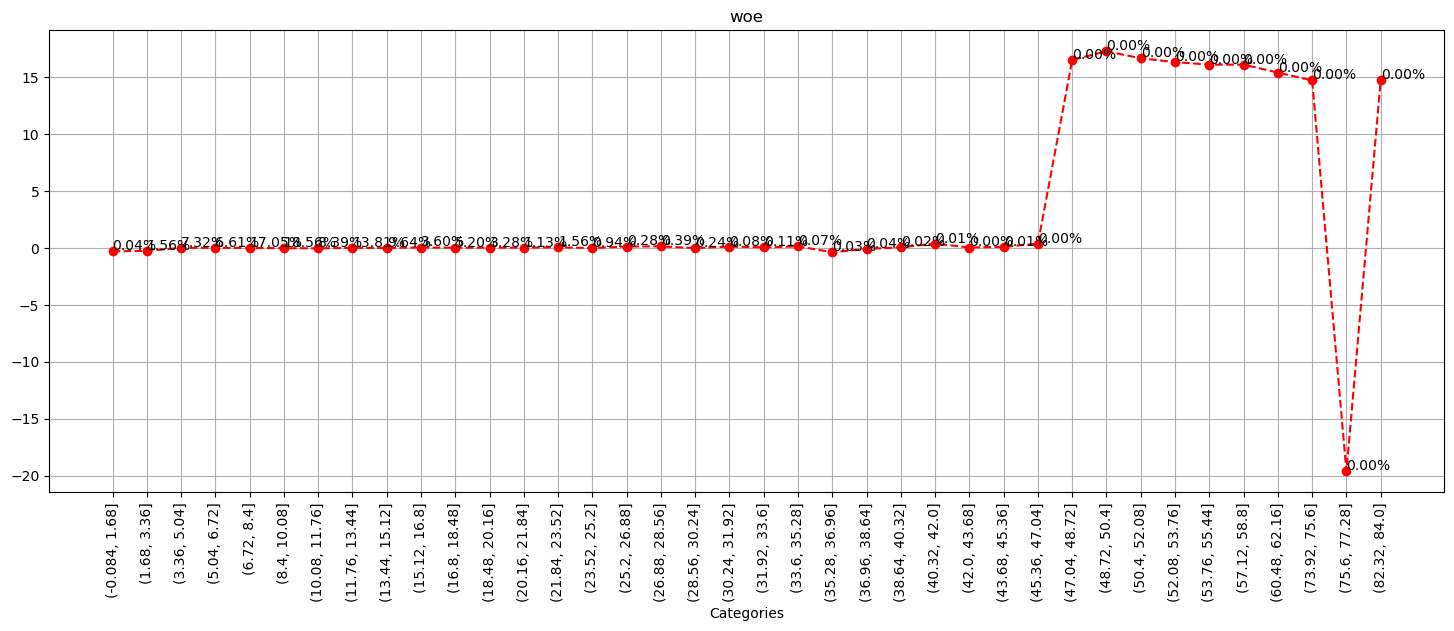

In [207]:
plot_woe(open_acc_woe['woe'], labels=open_acc_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [208]:
open_acc_groups.add_child(
        Interval().add_child(pd.Interval(left=48, right=np.inf, closed='right'))
    )

<Axes: title={'center': 'woe'}, xlabel='Categories'>

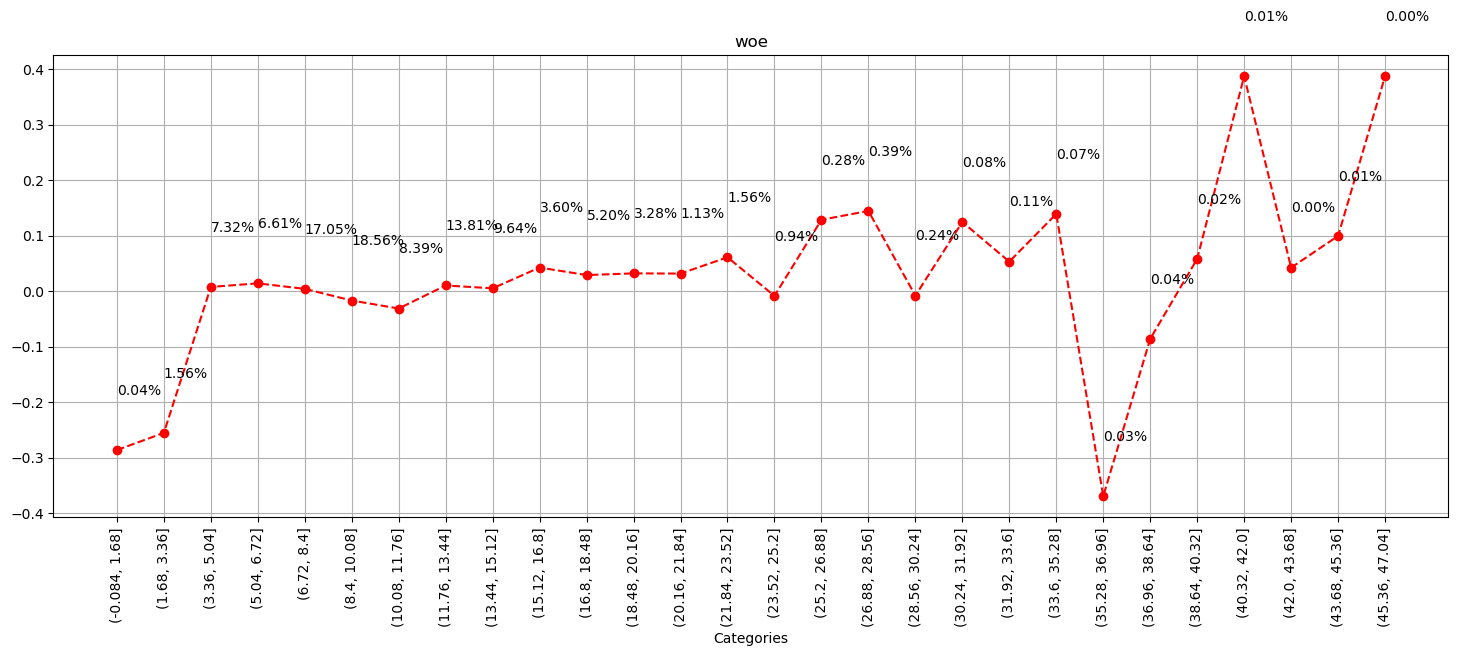

In [211]:
plot_woe(open_acc_woe['woe'][:28], labels=open_acc_woe['n_obs_rel'][:28].apply(lambda v: '{:.2%}'.format(v)))

In [126]:
open_acc_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=5, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=5, right=8, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=8, right=12, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=12, right=13, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=13, right=14, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=14, right=19, closed='right'))
    )

In [127]:
continuous_dft.add_child(open_acc_groups)

**pub_rec**

In [128]:
pub_rec_groups = GroupedColumn('pub_rec')

In [130]:
pub_rec_woe = calculate_woe_iv(
                    continuous_df,
                    continuous_df['pub_rec'],
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [132]:
pub_rec_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
pub_rec,,,,,,,,,,,,
0.0,44627,360295,404922,0.868400,8.755886e-01,0.867518,-0.009260,NaN,NaN,NaN,0.868400,0.002465
1.0,5572,47479,53051,0.113774,1.093235e-01,0.114320,0.044689,0.753198,0.766265,0.053949,0.982174,0.002465
2.0,543,5081,5624,0.012061,1.065374e-02,0.012234,0.138310,0.102086,0.098670,0.093621,0.994235,0.002465
3.0,135,1476,1611,0.003455,2.648721e-03,0.003554,0.293972,0.008680,0.008005,0.155662,0.997690,0.002465
4.0,47,473,520,0.001115,9.221472e-04,0.001139,0.211104,0.002415,0.001727,0.082868,0.998805,0.002465
5.0,25,251,276,0.000592,4.905038e-04,0.000604,0.208733,0.000535,0.000432,0.002371,0.999397,0.002465
6.0,10,126,136,0.000292,1.962015e-04,0.000303,0.435853,0.000301,0.000294,0.227120,0.999689,0.002465
7.0,5,57,62,0.000133,9.810077e-05,0.000137,0.335769,0.000166,0.000098,0.100083,0.999822,0.002465
8.0,1,28,29,0.000062,1.962015e-05,0.000067,1.234360,0.000070,0.000078,0.898591,0.999884,0.002465


<Axes: title={'center': 'woe'}, xlabel='Categories'>

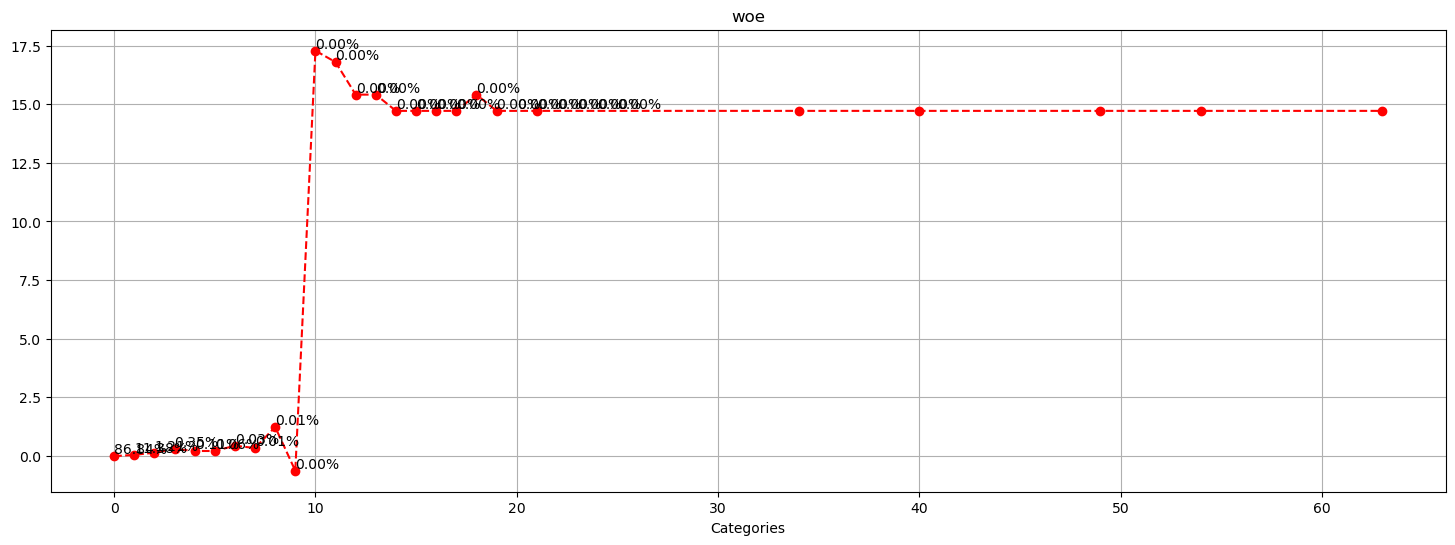

In [131]:
plot_woe(pub_rec_woe['woe'], labels=pub_rec_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [133]:
pub_rec_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=0, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=0, right=np.inf, closed='right'))
    )

In [134]:
continuous_dft.add_child(pub_rec_groups)

**total_acc**

In [135]:
total_acc_groups = GroupedColumn('total_acc')

In [136]:
total_acc_woe = calculate_woe_iv(
                    continuous_df,
                    continuous_df['total_acc'],
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

In [138]:
total_acc_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
total_acc,,,,,,,,,,,,
0.0,3,26,29,0.000062,5.886046e-05,0.000063,0.061640,NaN,NaN,NaN,0.000062,0.013727
1.0,4,17,21,0.000045,7.848062e-05,0.000041,-0.650925,0.000022,0.000020,0.712565,0.000107,0.013727
2.0,16,46,62,0.000133,3.139225e-04,0.000111,-1.041791,0.000070,0.000235,0.390866,0.000240,0.013727
3.0,92,380,472,0.001012,1.805054e-03,0.000915,-0.679461,0.000804,0.001491,0.362330,0.001252,0.013727
4.0,227,1277,1504,0.003225,4.453775e-03,0.003075,-0.370525,0.002160,0.002649,0.308936,0.004478,0.013727
5.0,328,2059,2387,0.005119,6.435410e-03,0.004958,-0.260882,0.001883,0.001982,0.109643,0.009597,0.013727
6.0,481,3131,3612,0.007746,9.437294e-03,0.007539,-0.224604,0.002581,0.003002,0.036278,0.017343,0.013727
7.0,630,4220,4850,0.010401,1.236070e-02,0.010161,-0.195974,0.002622,0.002923,0.028630,0.027745,0.013727
8.0,806,5474,6280,0.013468,1.581384e-02,0.013180,-0.182163,0.003019,0.003453,0.013811,0.041213,0.013727


<Axes: title={'center': 'woe'}, xlabel='Categories'>

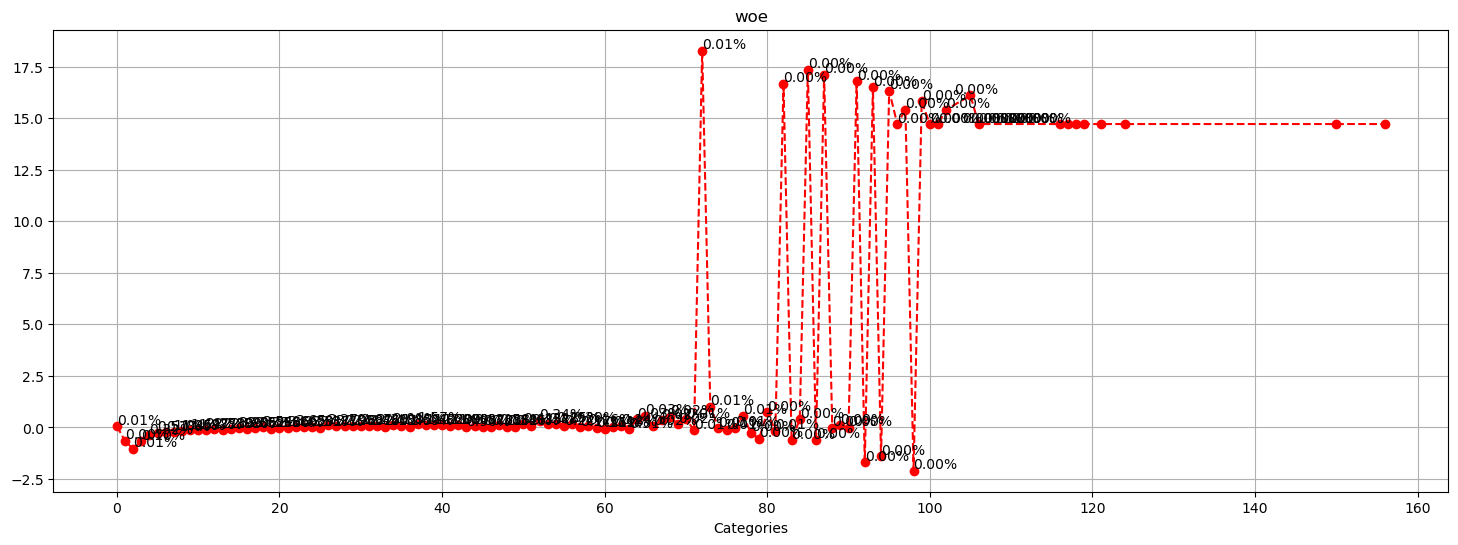

In [137]:
plot_woe(total_acc_woe['woe'], labels=total_acc_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [140]:
total_acc_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=25, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=25, right=45, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=45, right=np.inf, closed='right'))
    )

In [141]:
continuous_dft.add_child(total_acc_groups)

**acc_now_delinq**

In [142]:
acc_now_groups = GroupedColumn('acc_now_delinq')

In [143]:
acc_now_woe = calculate_woe_iv(
                    continuous_df,
                    continuous_df['acc_now_delinq'],
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

<Axes: title={'center': 'woe'}, xlabel='Categories'>

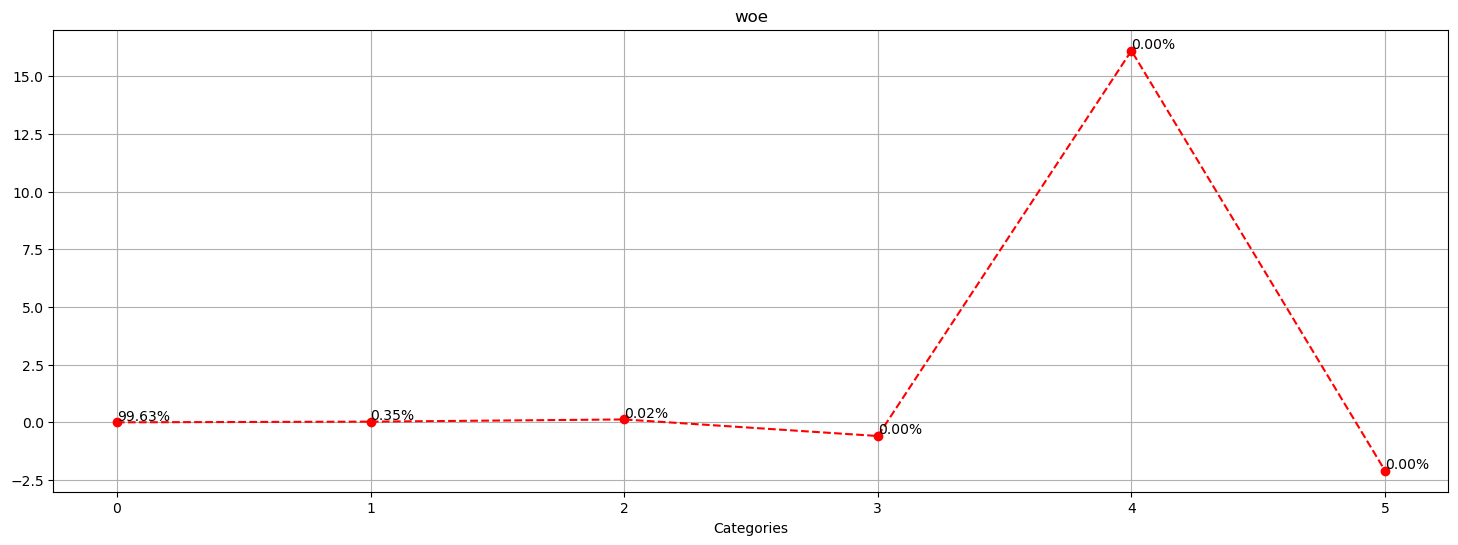

In [144]:
plot_woe(acc_now_woe['woe'], labels=acc_now_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [145]:
acc_now_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=0, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=0, right=np.inf, closed='right'))
    )

In [146]:
continuous_dft.add_child(acc_now_groups)

**Annual inc**

In [148]:
annual_inc_groups = GroupedColumn('annual_inc')

In [149]:
annual_inc_woe = calculate_woe_iv(
                    continuous_df,
                    pd.cut(continuous_df['annual_inc'], bins=100, retbins=False),
                    continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

KeyError: 'annual_inc'

- dti (debt to income ratio) -> similar to annual_inc
- mths_since_last_record -> similar to mths_since_last_delinq